# Set environment variables 

<font color="#445555">**Once you've set your Cloud Environment and loaded any needed packages, you're ready to start your analysis!**

In [28]:
%%capture
from firecloud import api as fapi
import os
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<font color="#445555">**Why is this necessary?**   
    To load the data into the notebook VM requires some information about the Terra workspace. You can access this programmatically by taking advantage of several useful environment variables, such as the workspace Google project and the workspace name. Pulling these pre-defined variables into the notebook VM makes the notebook work out-of-the-box without having to cut and paste **your specific variables** - even if you are running in a copy of the original workspace (with a different workspace name and workspace storage ID). 

In [29]:
# Get the Google billing project name and workspace name
project = os.environ['WORKSPACE_NAMESPACE']
workspace = os.environ['WORKSPACE_NAME']
bucket = os.environ['WORKSPACE_BUCKET'] + "/"

# Verify that we've captured the environment variables
print("Terra Billing project: " + project)
print("Workspace: " + workspace)
print("Workspace storage bucket: " + bucket)

# Copy all WHO growth parameter reference files from the workspace bucket to the notebook disk
!gsutil cp gs://fc-secure-1dd24c56-9f75-4720-a955-258cc33dbbc4/notebooks/WHO-growth-parameter-files/* .

!ls

Terra Billing project: foxg1-terra-billing-project
Workspace: foxg1-data-analysis
Workspace storage bucket: gs://fc-secure-1dd24c56-9f75-4720-a955-258cc33dbbc4/
Copying gs://fc-secure-1dd24c56-9f75-4720-a955-258cc33dbbc4/notebooks/WHO-growth-parameter-files/body-height-0-19-month-boys.csv...
Copying gs://fc-secure-1dd24c56-9f75-4720-a955-258cc33dbbc4/notebooks/WHO-growth-parameter-files/body-height-0-19-month-girls.csv...
Copying gs://fc-secure-1dd24c56-9f75-4720-a955-258cc33dbbc4/notebooks/WHO-growth-parameter-files/body-weight-0-10-month-boys.csv...
/ [3 files][ 43.8 KiB/ 43.8 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://fc-secure-1dd24c56-9f75-4720-a955-258cc33dbbc4/notebooks/WHO-growth-parameter-files/body-weight-

# Load patient data
First, load the data from the `patient_uuid` table in a pandas dataframe.   

Note that if you are **not using the standard genomic data model (i.e. participant, sample, pairs tables),** you will **need to include 'model = "flexible" in the command**.

In [4]:
# Get all of the data from the patient_uuid table and load into a pandas dataframe
patient_table = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "patient_uuid", model = "flexible").text), sep='\t')
patient_table.rename(columns = {'entity:patient_uuid_id':'patient_uuid'}, inplace = True)
patient_table.set_index('patient_uuid', inplace = True)

exam_findings_table = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "exam_findings", model = "flexible").text), sep='\t')

growth_parameters_table = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "growth_parameters", model = "flexible").text), sep='\t')
genetic_findings_table = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "genetic_findings", model = "flexible").text), sep='\t')
advese_effects_table = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "adverse_effects", model = "flexible").text), sep='\t')
clinical_diagnosis_table = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "clinical_diagnosis", model = "flexible").text), sep='\t')
exam_findings_table = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "exam_findings", model = "flexible").text), sep='\t')
patient_table.sample(5)



age_at_diagnosis date_of_birth  \
patient_uuid                                                           
d8dca022-552a-4636-b186-124135373bf6               1.0       10/6/14   
ec835c90-a3f6-446b-ad7c-6011b085f74e               3.0       3/20/08   
6e8a7113-2e40-4704-b82d-5bd35097a29a               3.0       6/18/10   
be0a9e57-635f-4e97-a25a-3b2f1520a503               1.0        7/3/17   
3dbc57b9-7185-44a5-8dc8-1168df48709e               8.0       5/31/09   

                                     most_recent_records_date     sex  
patient_uuid                                                           
d8dca022-552a-4636-b186-124135373bf6                  10/9/21    male  
ec835c90-a3f6-446b-ad7c-6011b085f74e                   3/1/22    male  
6e8a7113-2e40-4704-b82d-5bd35097a29a                  6/14/22    male  
be0a9e57-635f-4e97-a25a-3b2f1520a503                   9/6/21  female  
3dbc57b9-7185-44a5-8dc8-1168df48709e                  1/19/21  female

# Medications relations with variant types


There are 122 patients in the table


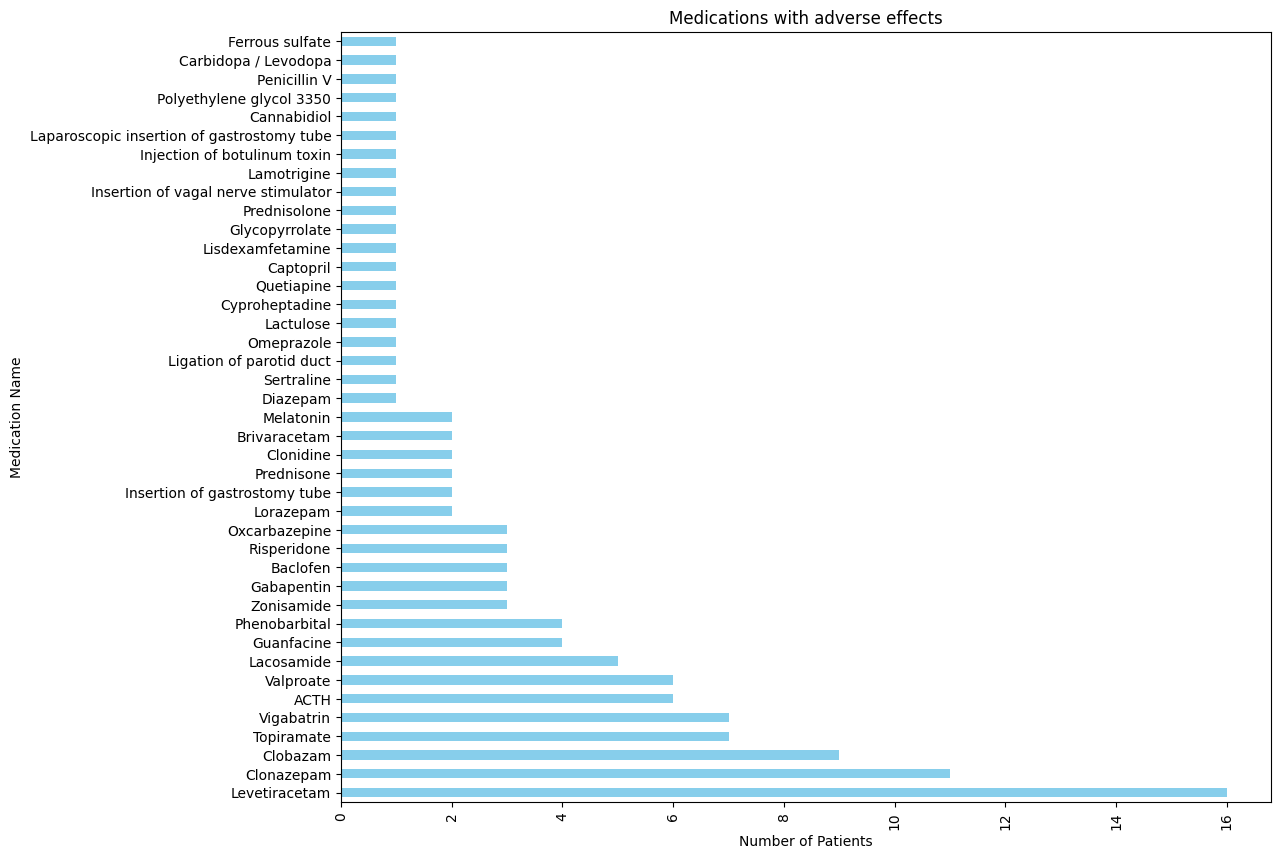

In [7]:
# Confirm the dataset loaded is what you expect
print(f'There are {len(advese_effects_table)} patients in the table')



# Take a look at the top of the table
advese_effects_table.head(n=5)


# Identifying the medications to which adverse reactions are seen
common_meds = advese_effects_table['medication_procedure'].value_counts()

# Plotting the most common medications
plt.figure(figsize=(12, 10))
common_meds.plot(kind='barh', color='skyblue')
plt.title('Medications with adverse effects')
plt.ylabel('Medication Name')
plt.xlabel('Number of Patients')
plt.xticks(rotation=90)
plt.show()


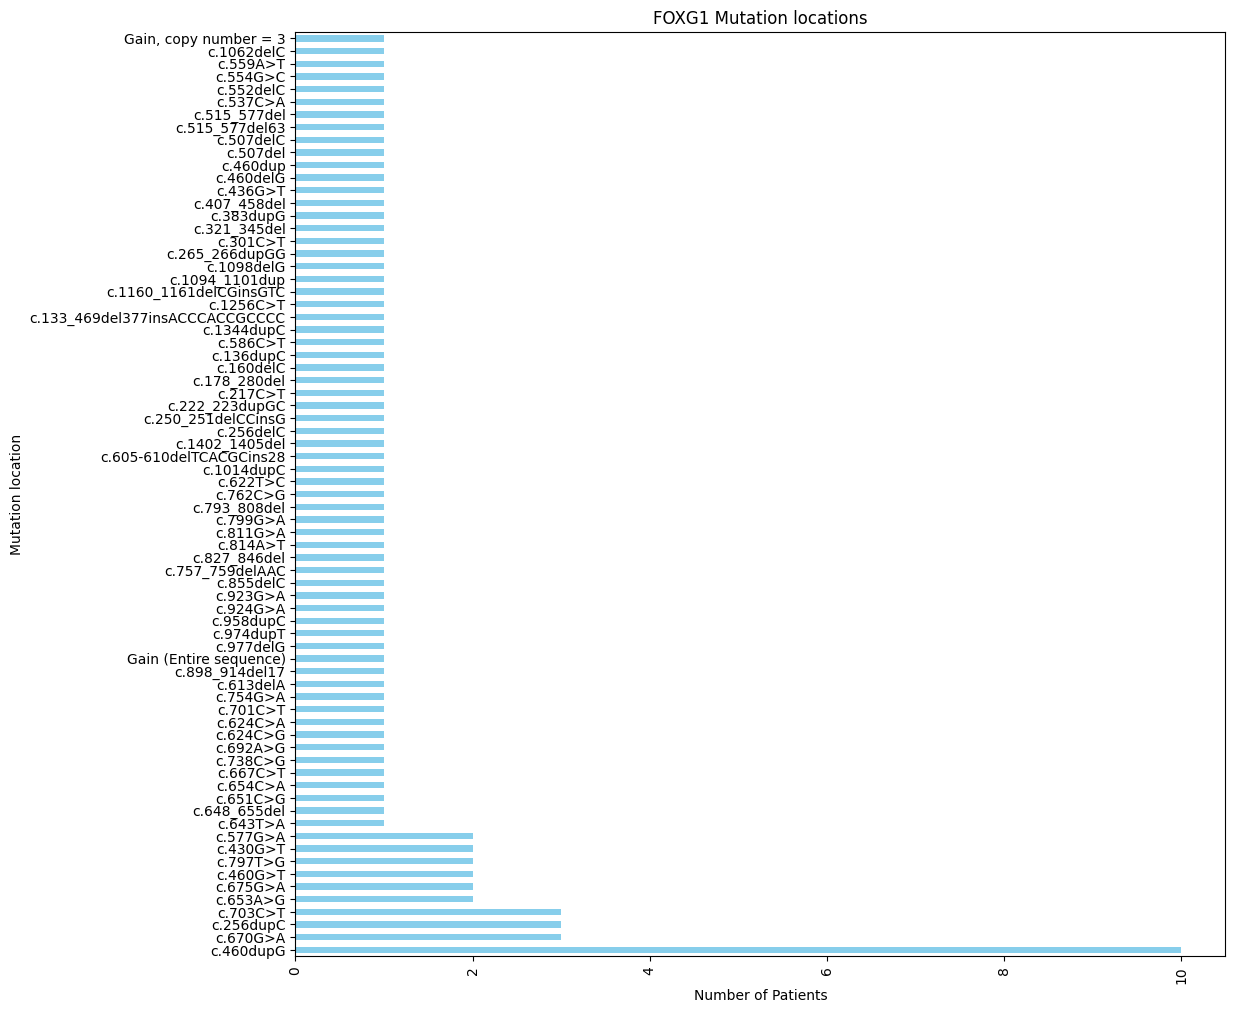

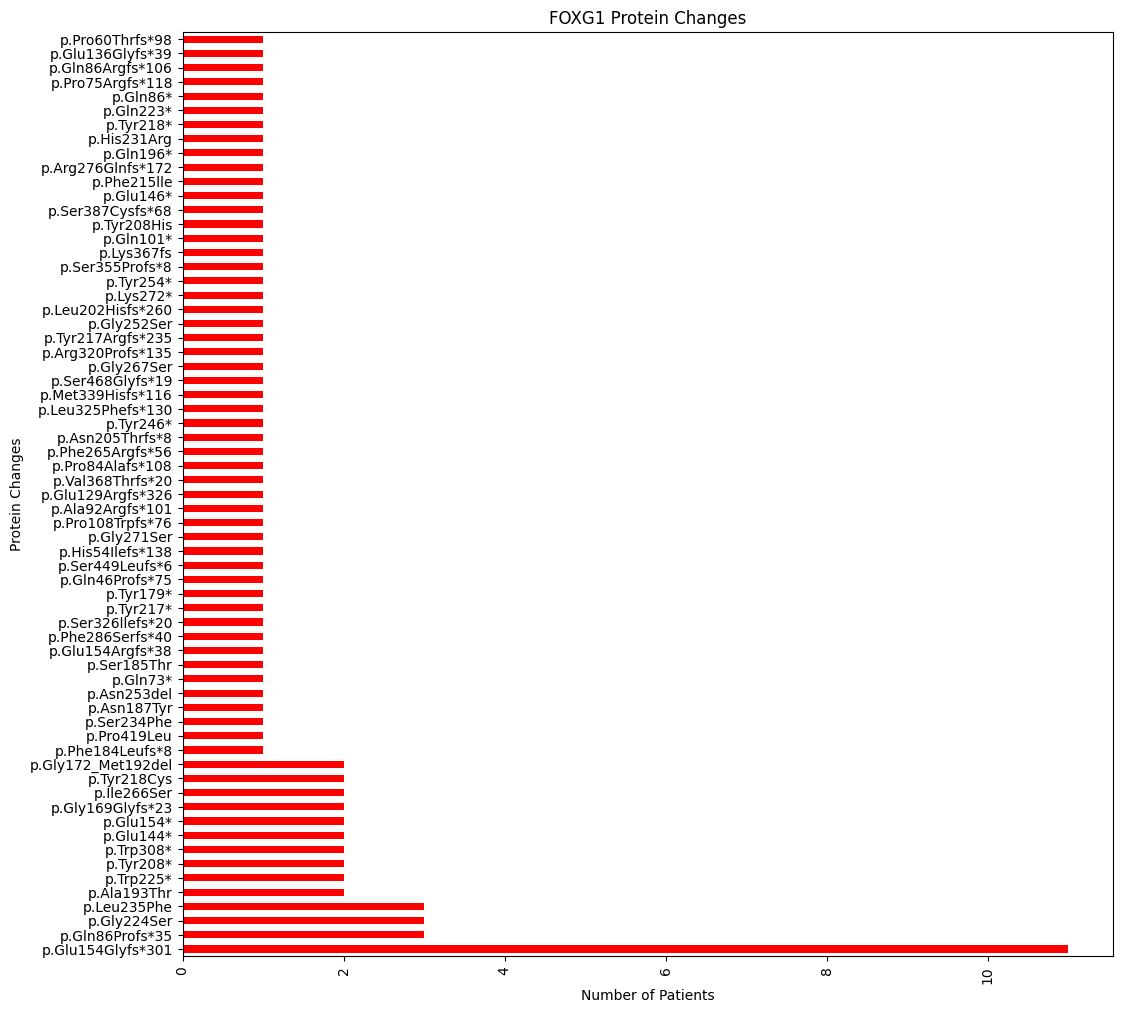

In [8]:

# Identifying the common mutation locations 
genetic_findings_table_foxg1 = genetic_findings_table.loc[genetic_findings_table['gene'] == "FOXG1"]
sorted_frame = genetic_findings_table_foxg1.sort_values(by='variant_DNA', key=lambda x: x.str[2:5])
common_mutation_types = sorted_frame['variant_DNA'].value_counts()

# Plotting the most common medications
plt.figure(figsize=(12, 12))
common_mutation_types.plot(kind='barh', color='skyblue')
plt.title('FOXG1 Mutation locations')
plt.xlabel('Number of Patients')
plt.ylabel('Mutation location')
plt.xticks(rotation=90)
plt.show()



## # Identifying the protein changes 

common_protein_changes = genetic_findings_table_foxg1['variant_protein'].value_counts()

# Plotting the most common medications
plt.figure(figsize=(12, 12))
common_protein_changes.plot(kind='barh', color='red')
plt.title('FOXG1 Protein Changes')
plt.xlabel('Number of Patients')
plt.ylabel('Protein Changes')
plt.xticks(rotation=90)
plt.show()

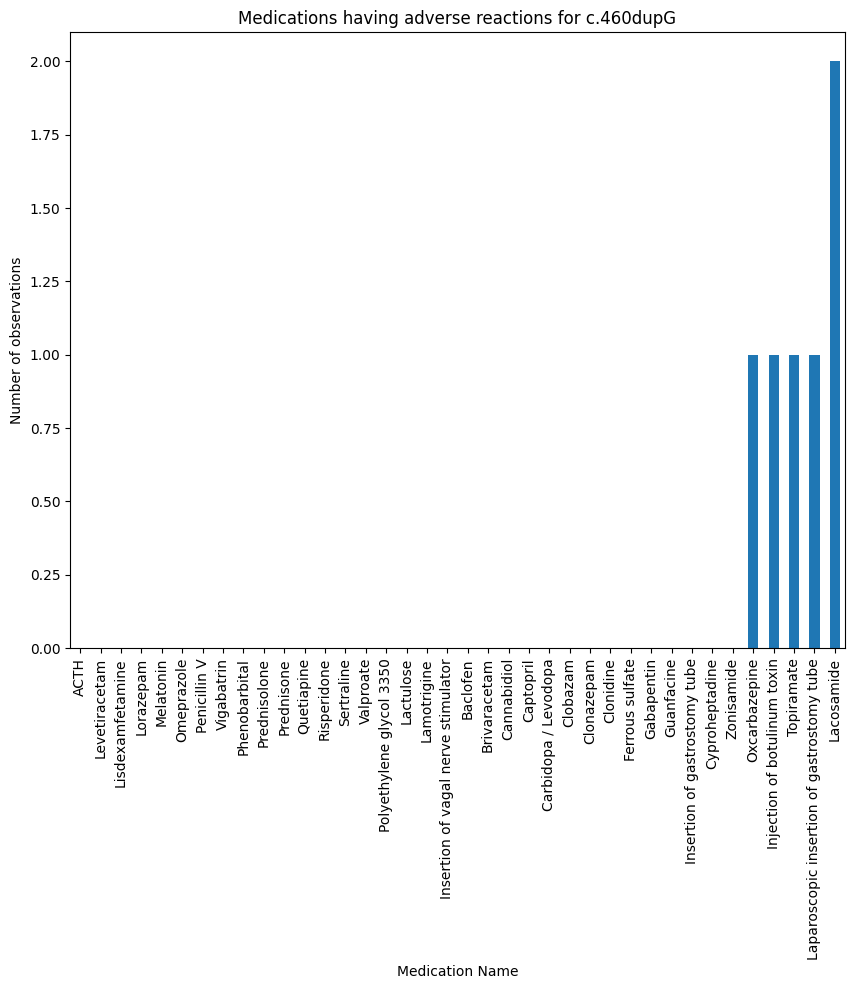

In [9]:
# Show medications with adverse reaction by mutation types
# Merging the two DataFrames
merged_data = pd.merge(advese_effects_table, genetic_findings_table_foxg1, on='patient_uuid', how='inner')

# Grouping by mutation type and listing out medications
medications_by_mutation = merged_data.groupby('variant_DNA')['medication_procedure'].unique()

# Counting the number of times each medication is prescribed per mutation
medication_counts_by_mutation = merged_data.groupby('variant_DNA')['medication_procedure'].value_counts().unstack().fillna(0)



medication_counts_by_mutation.head(n=5)
#If you want to visualize the most common medications for a specific mutation:

import matplotlib.pyplot as plt

mutation_of_interest = "c.460dupG"
medication_counts_by_mutation.loc[mutation_of_interest].sort_values().plot(kind='bar', figsize=(10, 8))
plt.title(f"Medications having adverse reactions for {mutation_of_interest}")
plt.xlabel('Medication Name')
plt.ylabel('Number of observations')
plt.show()





# Exam findings

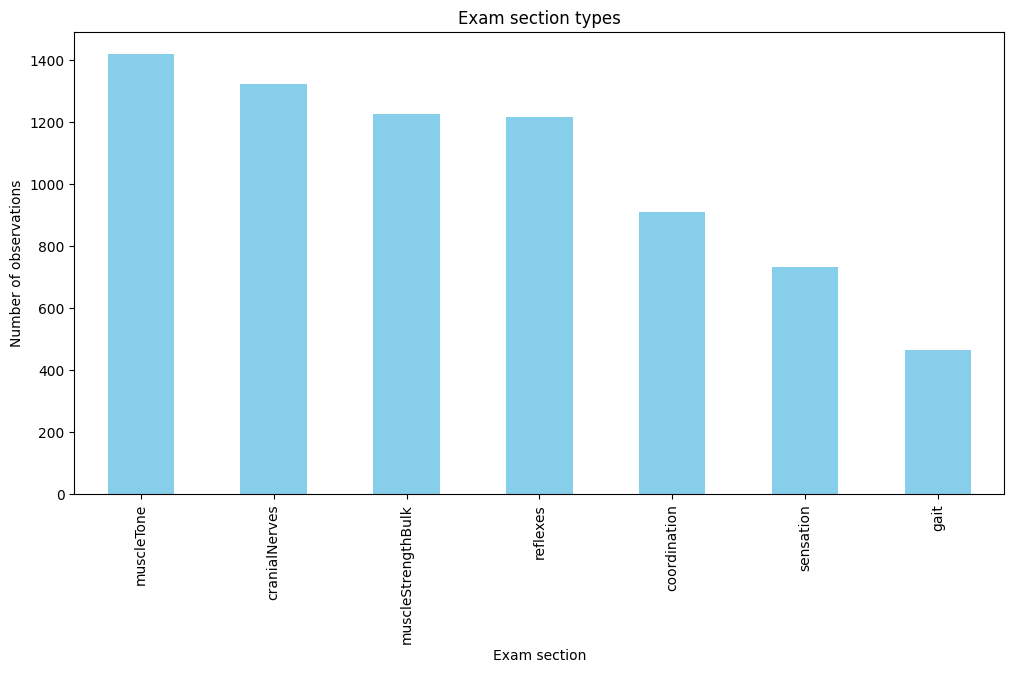

In [10]:
# Show exam findings

exam_findings_table = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "exam_findings", model = "flexible").text), sep='\t')

# Identifying the exam sections 
exam_section = exam_findings_table['exam_section'].value_counts()

# Plotting the exam sections
plt.figure(figsize=(12, 6))
exam_section.plot(kind='bar', color='skyblue')
plt.title('Exam section types')
plt.ylabel('Number of observations')
plt.xlabel('Exam section')
plt.xticks(rotation=90)
plt.show()

exam_finding
Unable to walk                     362
Poor visual tracking               255
Antigravity strength               239
Decreased muscle tone              238
Sensation grossly intact           171
Generalized hypotonia              142
Axial hypotonia                    133
Head lag                           127
Brisk tendon reflex                118
Choreoathetosis                    118
Reduction of muscle bulk           110
Chorea                              99
Hyporeflexia                        95
Appendicular hypertonia             91
Sensitive to touch                  69
Esotropia                           67
Truncal hypotonia                   66
Mild hypotonia                      63
Hypotonia                           63
Lower limb spasticity               62
Dystonia                            58
Dysconjugate gaze                   56
Muscle weakness                     54
Cranial nerves grossly intact       53
Mixed muscle tone                   53
Hypertonia, 

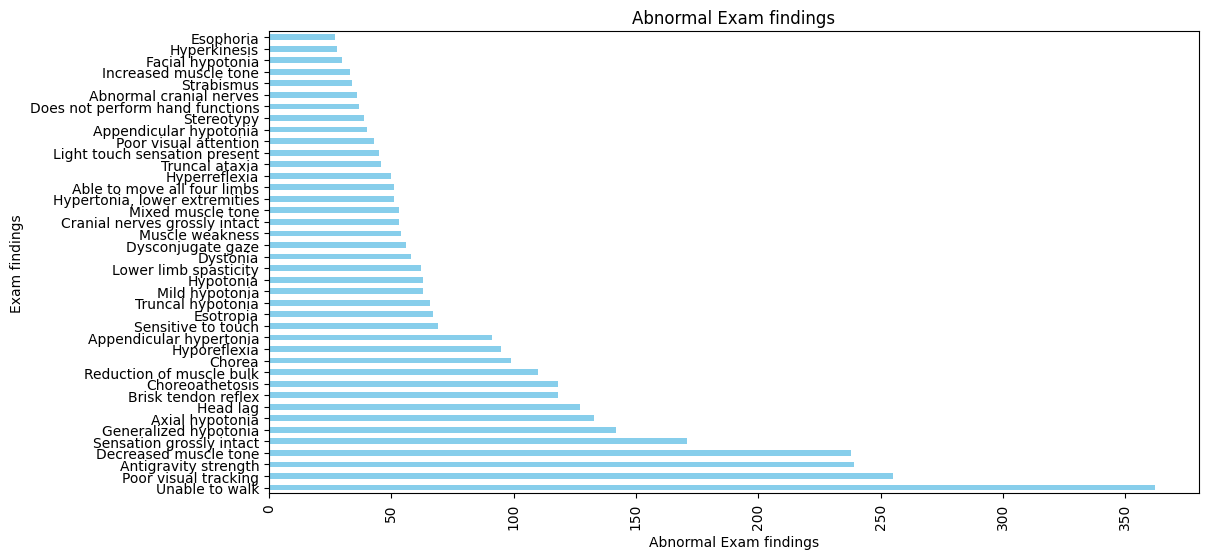

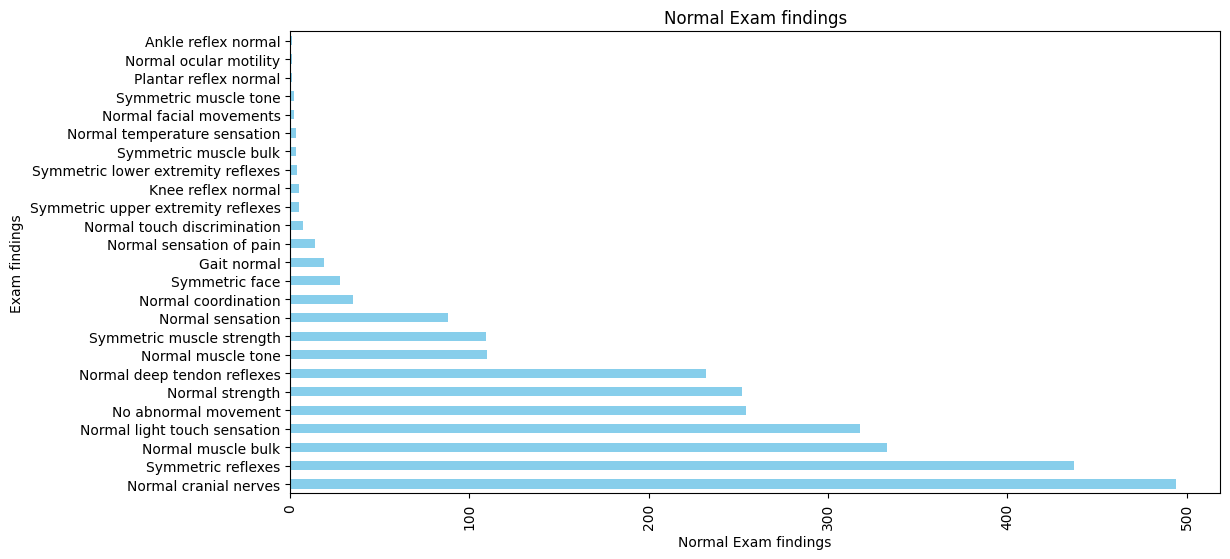

In [11]:
# Identifying the abnormal and normal exam findings 

search_words = ["normal", "symmetric", "No abnormal"]
pattern = r'\b(?:' + '|'.join(search_words) + r')\b'
mask = ~exam_findings_table['exam_finding'].str.contains(pattern, case=False, na=False)
abnormal_exam_findings = exam_findings_table[mask]

mask1 = exam_findings_table['exam_finding'].str.contains(pattern, case=False, na=False)

normal_exam_findings = exam_findings_table[mask1]

abnormal_exam_findings.sample(5)

abnormal_exam_findings_count = abnormal_exam_findings['exam_finding'].value_counts().nlargest(40)
normal_exam_findings_count = normal_exam_findings['exam_finding'].value_counts().nlargest(40)

print(abnormal_exam_findings_count)



# Plotting the abnormal exam findings
plt.figure(figsize=(12, 6))
abnormal_exam_findings_count.plot(kind='barh', color='skyblue')
plt.title('Abnormal Exam findings')
plt.ylabel('Exam findings')
plt.xlabel('Abnormal Exam findings')
plt.xticks(rotation=90)
plt.show()


# Plotting the normal exam findings
plt.figure(figsize=(12, 6))
normal_exam_findings_count.plot(kind='barh', color='skyblue')
plt.title('Normal Exam findings')
plt.ylabel('Exam findings')
plt.xlabel('Normal Exam findings')
plt.xticks(rotation=90)
plt.show()

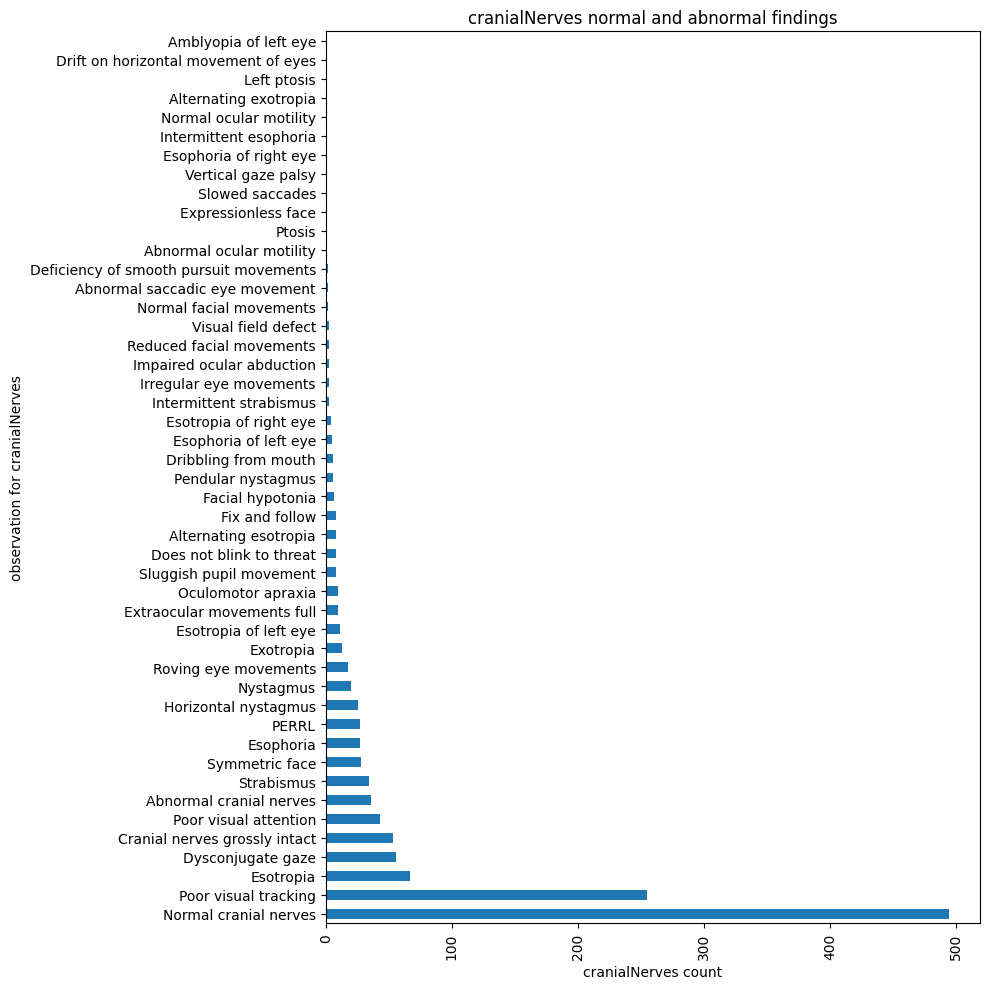

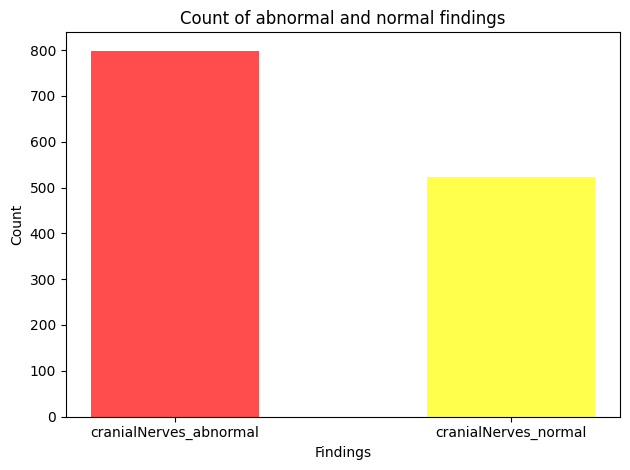

In [12]:
# In each exam_section observe variations

## This is for cranial nerves

cranialNerves = exam_findings_table.loc[exam_findings_table['exam_section'] == "cranialNerves"]

search_words = ["Symmetric face", "Normal cranial nerves"]
pattern = r'\b(?:' + '|'.join(search_words) + r')\b'
mask = ~cranialNerves['exam_finding'].str.contains(pattern, case=False, na=False)
cranialNerves_abnormal = cranialNerves[mask]
abnormal_count=cranialNerves_abnormal['exam_finding'].value_counts()

mask1 = cranialNerves['exam_finding'].str.contains(pattern, case=False, na=False)
cranialNerves_normal = cranialNerves[mask1]
normal_count=cranialNerves_normal['exam_finding'].value_counts()


import matplotlib.pyplot as plt

ax = cranialNerves['exam_finding'].value_counts().plot(kind='barh', figsize=(10, 10))
plt.xlabel('cranialNerves count')
plt.ylabel('observation for cranialNerves')
plt.title('cranialNerves normal and abnormal findings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


######## Total normal vs abnormal findings for cranial nerves section

# Define the bar positions and width
bar_positions = [0, 1]
bar_width = 0.5
items = ['cranialNerves_abnormal', 'cranialNerves_normal']
counts = [cranialNerves_abnormal.shape[0], cranialNerves_normal.shape[0]]


# Create the bar chart
plt.bar(bar_positions, counts, width=bar_width, color=['red', 'yellow'], alpha=0.7)

# Label the bars with the item names
plt.xticks(bar_positions, items)

# Add title and axis labels
plt.title('Count of abnormal and normal findings')
plt.ylabel('Count')
plt.xlabel('Findings')

# Display the plot
plt.tight_layout()
plt.show()



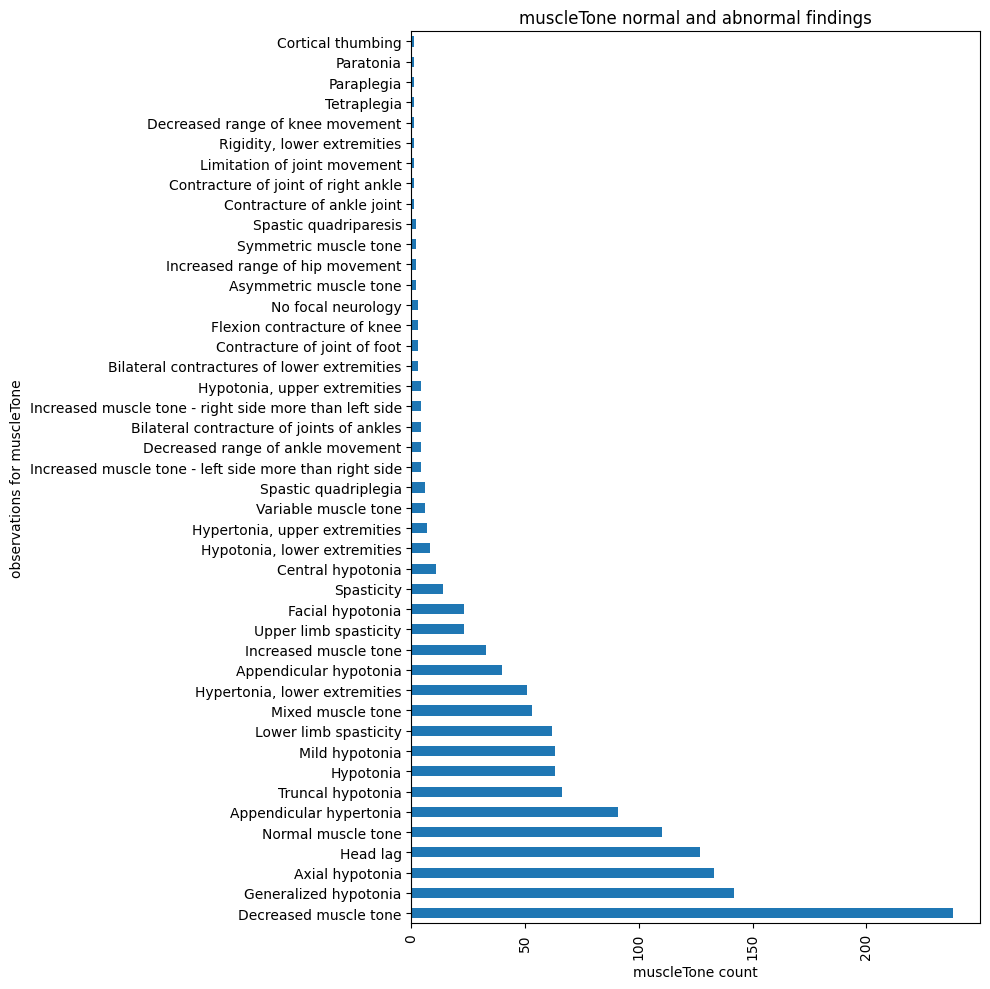

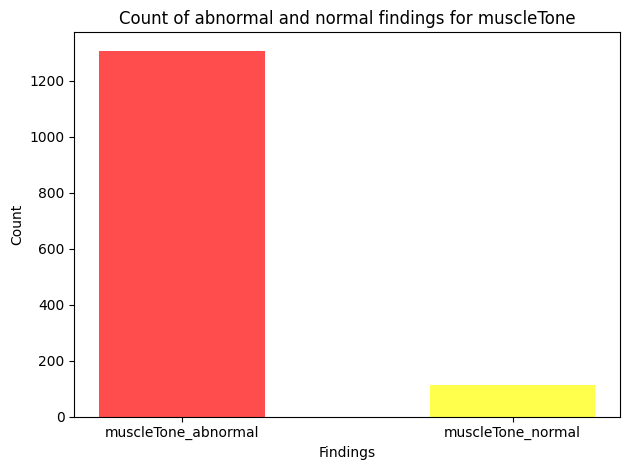

In [13]:
# In each exam_section observe variations

## This is for muscleTone

muscleTone = exam_findings_table.loc[exam_findings_table['exam_section'] == "muscleTone"]

search_words = ["Symmetric muscle tone", "Normal muscle tone"]
pattern = r'\b(?:' + '|'.join(search_words) + r')\b'
mask = ~muscleTone['exam_finding'].str.contains(pattern, case=False, na=False)
muscleTone_abnormal = muscleTone[mask]
abnormal_count=muscleTone_abnormal['exam_finding'].value_counts()

mask1 = muscleTone['exam_finding'].str.contains(pattern, case=False, na=False)
muscleTone_normal = muscleTone[mask1]
normal_count=muscleTone_normal['exam_finding'].value_counts()


import matplotlib.pyplot as plt

ax = muscleTone['exam_finding'].value_counts().plot(kind='barh', figsize=(10, 10))
plt.xlabel('muscleTone count')
plt.ylabel('observations for muscleTone')
plt.title('muscleTone normal and abnormal findings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


######## Total normal vs abnormal findings for cranial nerves section

# Define the bar positions and width
bar_positions = [0, 1]
bar_width = 0.5
items = ['muscleTone_abnormal', 'muscleTone_normal']
counts = [muscleTone_abnormal.shape[0], muscleTone_normal.shape[0]]


# Create the bar chart
plt.bar(bar_positions, counts, width=bar_width, color=['red', 'yellow'], alpha=0.7)

# Label the bars with the item names
plt.xticks(bar_positions, items)

# Add title and axis labels
plt.title('Count of abnormal and normal findings for muscleTone')
plt.ylabel('Count')
plt.xlabel('Findings')

# Display the plot
plt.tight_layout()
plt.show()



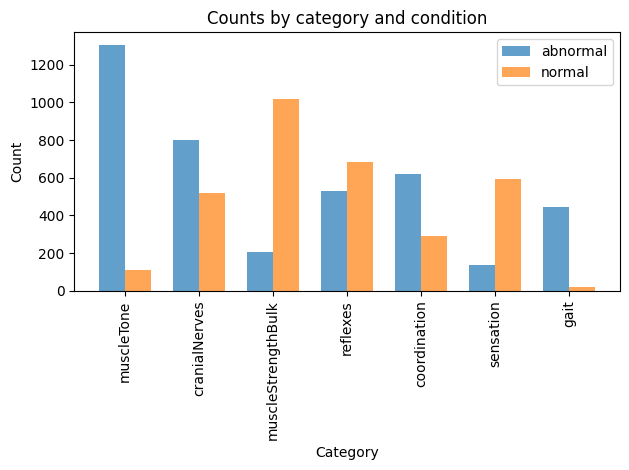

In [14]:
# muscleTone

muscleTone = exam_findings_table.loc[exam_findings_table['exam_section'] == "muscleTone"]

search_words = ["Symmetric muscle tone", "Normal muscle tone"]
pattern = r'\b(?:' + '|'.join(search_words) + r')\b'

mask = ~muscleTone['exam_finding'].str.contains(pattern, case=False, na=False)
muscleTone_abnormal = muscleTone[mask]

mask1 = muscleTone['exam_finding'].str.contains(pattern, case=False, na=False)
muscleTone_normal = muscleTone[mask1]

# cranialNerves

cranialNerves = exam_findings_table.loc[exam_findings_table['exam_section'] == "cranialNerves"]

search_words = ["Symmetric face", "Normal cranial nerves"]
pattern = r'\b(?:' + '|'.join(search_words) + r')\b'

mask = ~cranialNerves['exam_finding'].str.contains(pattern, case=False, na=False)
cranialNerves_abnormal = cranialNerves[mask]

mask1 = cranialNerves['exam_finding'].str.contains(pattern, case=False, na=False)
cranialNerves_normal = cranialNerves[mask1]

# muscleStrengthBulk

muscleStrengthBulk = exam_findings_table.loc[exam_findings_table['exam_section'] == "muscleStrengthBulk"]

search_words = ["Able to move all four limbs", "Antigravity strength", "Normal muscle bulk", "Normal strength",
               "Symmetric muscle bulk", "Symmetric muscle strength", "Weight-bearing"]
pattern = r'\b(?:' + '|'.join(search_words) + r')\b'

mask = ~muscleStrengthBulk['exam_finding'].str.contains(pattern, case=False, na=False)
muscleStrengthBulk_abnormal = muscleStrengthBulk[mask]

mask1 = muscleStrengthBulk['exam_finding'].str.contains(pattern, case=False, na=False)
muscleStrengthBulk_normal = muscleStrengthBulk[mask1]

# reflexes

reflexes = exam_findings_table.loc[exam_findings_table['exam_section'] == "reflexes"]

search_words = ["Ankle reflex normal", "Knee reflex normal", "Moro reflex absent", "Normal deep tendon reflexes",
               "Symmetric reflexes", "Symmetric upper extremity reflexes", "Symmetric lower extremity reflexes"]
pattern = r'\b(?:' + '|'.join(search_words) + r')\b'

mask = ~reflexes['exam_finding'].str.contains(pattern, case=False, na=False)
reflexes_abnormal = reflexes[mask]

mask1 = reflexes['exam_finding'].str.contains(pattern, case=False, na=False)
reflexes_normal = reflexes[mask1]

# coordination

coordination = exam_findings_table.loc[exam_findings_table['exam_section'] == "coordination"]

search_words = ["No abnormal movement", "Normal coordination"]
pattern = r'\b(?:' + '|'.join(search_words) + r')\b'

mask = ~coordination['exam_finding'].str.contains(pattern, case=False, na=False)
coordination_abnormal = coordination[mask]

mask1 = coordination['exam_finding'].str.contains(pattern, case=False, na=False)
coordination_normal = coordination[mask1]

# sensation

sensation = exam_findings_table.loc[exam_findings_table['exam_section'] == "sensation"]

search_words = ["Normal light touch sensation", "Normal sensation", "Normal sensation of pain" , "Normal temperature sensation",
               "Normal touch discriminatio", "Sensation grossly intact"]
pattern = r'\b(?:' + '|'.join(search_words) + r')\b'

mask = ~sensation['exam_finding'].str.contains(pattern, case=False, na=False)
sensation_abnormal = sensation[mask]

mask1 = sensation['exam_finding'].str.contains(pattern, case=False, na=False)
sensation_normal = sensation[mask1]

# gait

gait = exam_findings_table.loc[exam_findings_table['exam_section'] == "gait"]

search_words = ["Gait normal"]
pattern = r'\b(?:' + '|'.join(search_words) + r')\b'

mask = ~gait['exam_finding'].str.contains(pattern, case=False, na=False)
gait_abnormal = gait[mask]

mask1 = gait['exam_finding'].str.contains(pattern, case=False, na=False)
gait_normal = gait[mask1]


####################

categories = ['muscleTone', 'cranialNerves', 'muscleStrengthBulk', 'reflexes', 'coordination',
             'sensation', 'gait']

# Assuming the two counts represent two different measurements, e.g., '2019' and '2020'
conditions = ['abnormal', 'normal']

data = {
    'muscleTone': [muscleTone_abnormal.shape[0], muscleTone_normal.shape[0]],
    'cranialNerves': [cranialNerves_abnormal.shape[0], cranialNerves_normal.shape[0]],
    'muscleStrengthBulk': [muscleStrengthBulk_abnormal.shape[0], muscleStrengthBulk_normal.shape[0]],
    'reflexes': [reflexes_abnormal.shape[0], reflexes_normal.shape[0]],
    'coordination': [coordination_abnormal.shape[0], coordination_normal.shape[0]],
    'sensation': [sensation_abnormal.shape[0], sensation_normal.shape[0]],
    'gait': [gait_abnormal.shape[0], gait_normal.shape[0]]
}

import numpy as np
import matplotlib.pyplot as plt

# Number of categories
n_categories = len(categories)

# Width of a bar
bar_width = 0.35

# Positions for each category group
index = np.arange(n_categories)

# Create grouped bars for each category
for i, condition in enumerate(conditions):
    plt.bar(index + i * bar_width, [data[cat][i] for cat in categories], bar_width, alpha=0.7, label=condition)

# Adjust the x ticks and labels
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Counts by category and condition')
plt.xticks(index + bar_width / 2, categories, rotation=90)  # Centering the xtick labels between the grouped bars
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()



# Analyze primary diagnosis and genetic findings

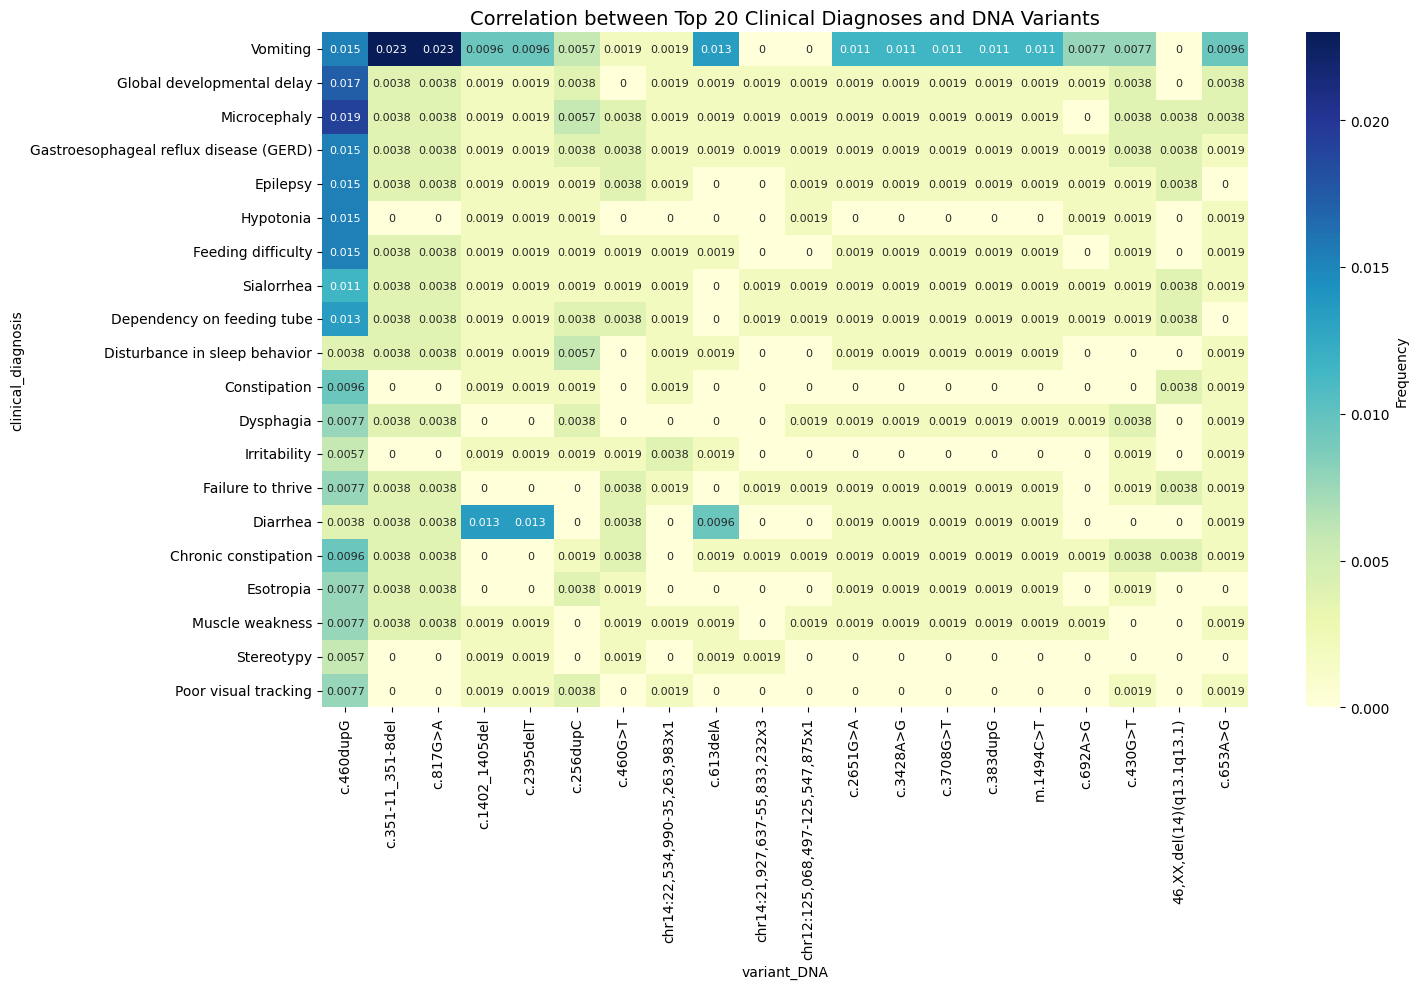

In [15]:
# First, import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Load both CSVs into dataframes


clinical_diagnosis = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "clinical_diagnosis", model = "flexible").text), sep='\t')
genetic_findings = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "genetic_findings", model = "flexible").text), sep='\t')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Data Preparation
clinical_df = clinical_diagnosis
genetic_df = genetic_findings

# 2. Merge Tables
merged_df = pd.merge(clinical_df, genetic_df[['patient_uuid', 'variant_DNA']], on='patient_uuid', how='inner')

# 3. Data Analysis
# a. Descriptive Statistics
frequency_table = merged_df.groupby(['clinical_diagnosis', 'variant_DNA']).size().unstack(fill_value=0)

# Focus on the top N frequent variants and diagnoses
N = 20  # Change this value to adjust the number of top entries you want to consider

# Top N variants
top_variants = frequency_table.sum(axis=0).nlargest(N).index
# Top N diagnoses
top_diagnoses = frequency_table.sum(axis=1).nlargest(N).index

filtered_table = frequency_table.loc[top_diagnoses, top_variants]

# Normalize the frequency_table to reflect densities
normalized_table = filtered_table / filtered_table.sum().sum()

# 4. Visualization
# a. Heatmap
plt.figure(figsize=(15, 10))  # Increase figure size

# Custom settings for x and y ticks
xticklabels = filtered_table.columns
yticklabels = filtered_table.index
sns.heatmap(normalized_table, cmap="YlGnBu", annot=True, cbar_kws={'label': 'Frequency'},
            xticklabels=xticklabels, yticklabels=yticklabels, 
            annot_kws={"size": 8})  # Decrease annotation font size if needed

plt.title(f'Correlation between Top {N} Clinical Diagnoses and DNA Variants', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)  # No rotation for y-axis labels as they're usually more readable horizontally
plt.tight_layout()
plt.show()





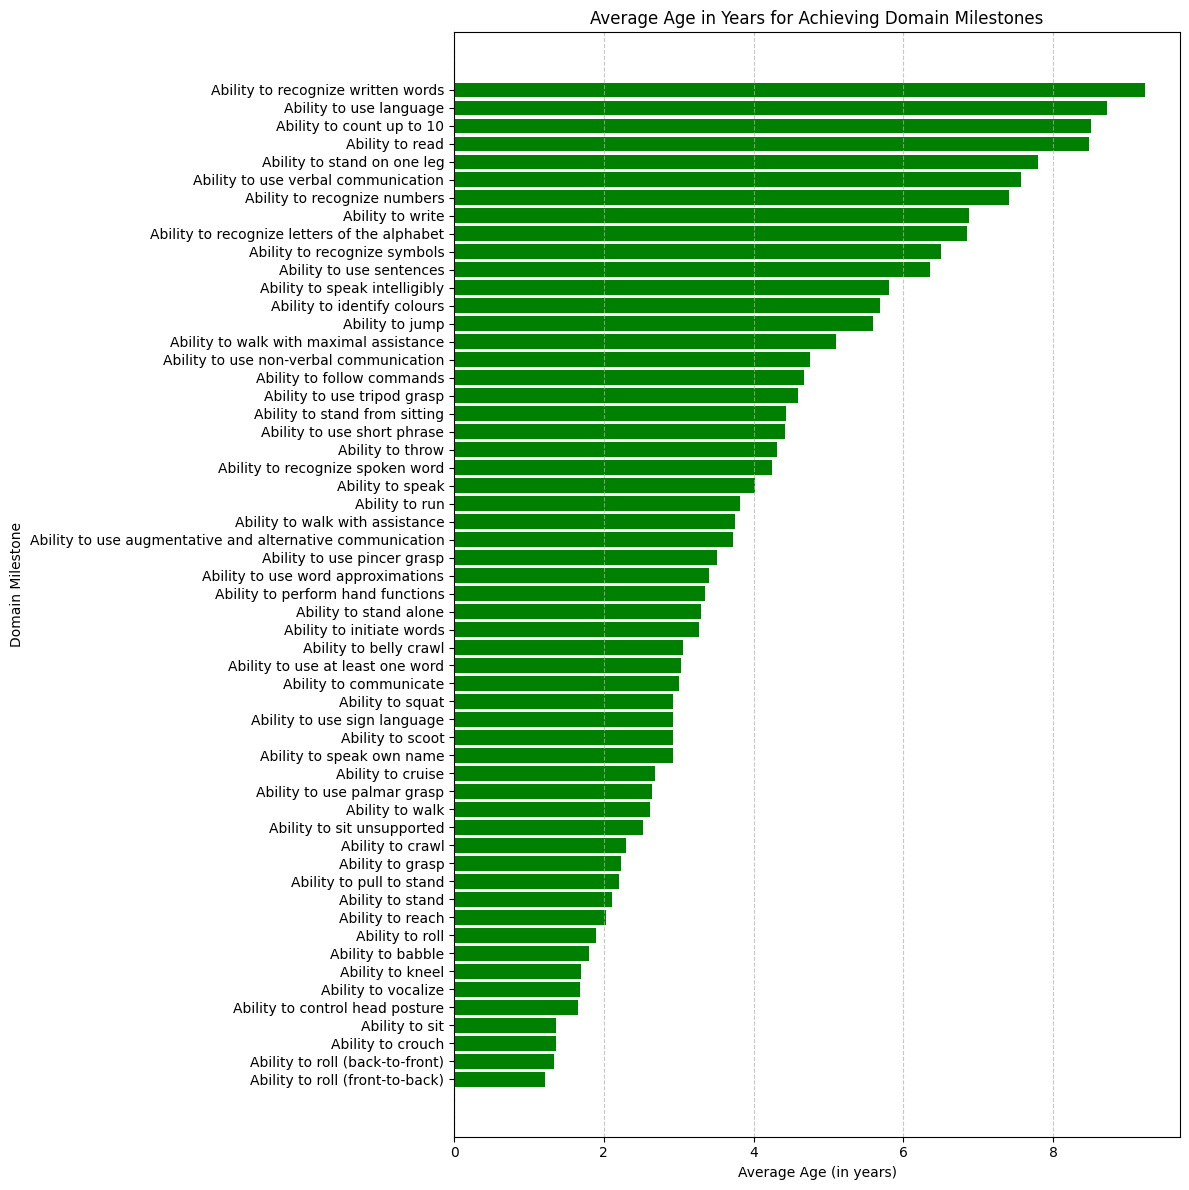

In [16]:
## this plot shows 

import pandas as pd
import matplotlib.pyplot as plt



# Load the data
development_df = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "development", model = "flexible").text), sep='\t')


# Filter the dataframe for only rows where domain_status is 'able'
able_df = development_df[development_df['domain_status'] == 'Able']

# Identify the first time each patient achieved each milestone
first_able_df = able_df.groupby(['patient_uuid', 'domain_milestone'])['domain_age_days_firstDate'].min().reset_index()

# Group by domain_milestone to get the average age across all patients for each milestone
avg_age_per_milestone = first_able_df.groupby('domain_milestone')['domain_age_days_firstDate'].mean()

# Convert the average age from days to years
avg_age_per_milestone_in_years = avg_age_per_milestone / 365.25

# Sort the milestones by average age
avg_age_per_milestone_in_years = avg_age_per_milestone_in_years.sort_values()

# Create a time series plot
plt.figure(figsize=(12, 12))

# Plotting the average age for each milestone
plt.barh(avg_age_per_milestone_in_years.index, avg_age_per_milestone_in_years.values, color='green')

plt.title('Average Age in Years for Achieving Domain Milestones')
plt.xlabel('Average Age (in years)')
plt.ylabel('Domain Milestone')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()







/tmp/ipykernel_114/1505085907.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(avg_age_per_milestone_in_years, shade=True, color='green')


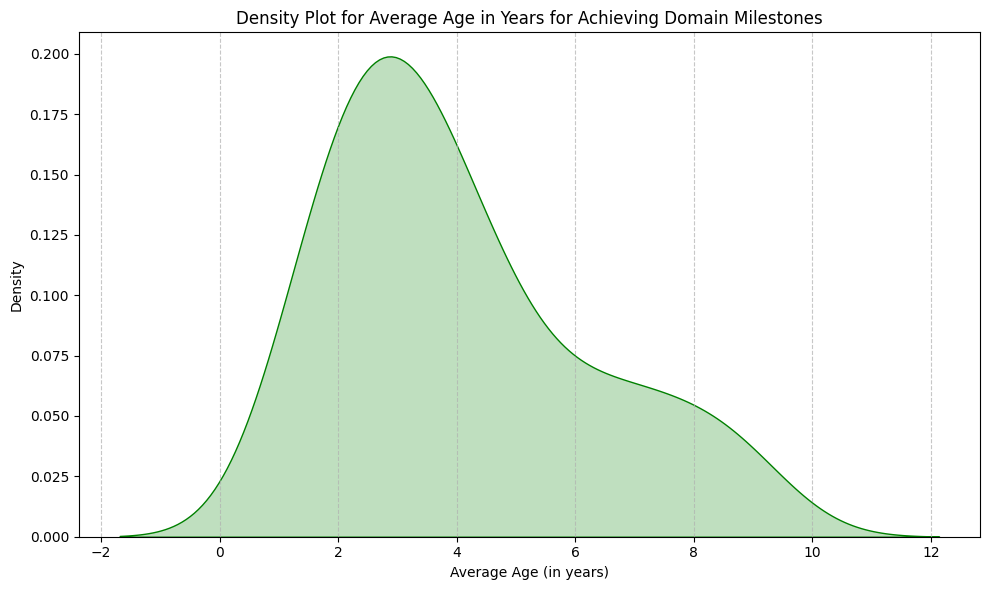

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
development_df = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "development", model = "flexible").text), sep='\t')

# Filter the dataframe for only rows where domain_status is 'able'
able_df = development_df[development_df['domain_status'] == 'Able']

# Identify the first time each patient achieved each milestone
first_able_df = able_df.groupby(['patient_uuid', 'domain_milestone'])['domain_age_days_firstDate'].min().reset_index()

# Group by domain_milestone to get the average age across all patients for each milestone
avg_age_per_milestone = first_able_df.groupby('domain_milestone')['domain_age_days_firstDate'].mean()

# Convert the average age from days to years
avg_age_per_milestone_in_years = avg_age_per_milestone / 365.25

# Create the KDE plot using seaborn
plt.figure(figsize=(10, 6))
sns.kdeplot(avg_age_per_milestone_in_years, shade=True, color='green')
plt.title('Density Plot for Average Age in Years for Achieving Domain Milestones')
plt.xlabel('Average Age (in years)')
plt.ylabel('Density')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


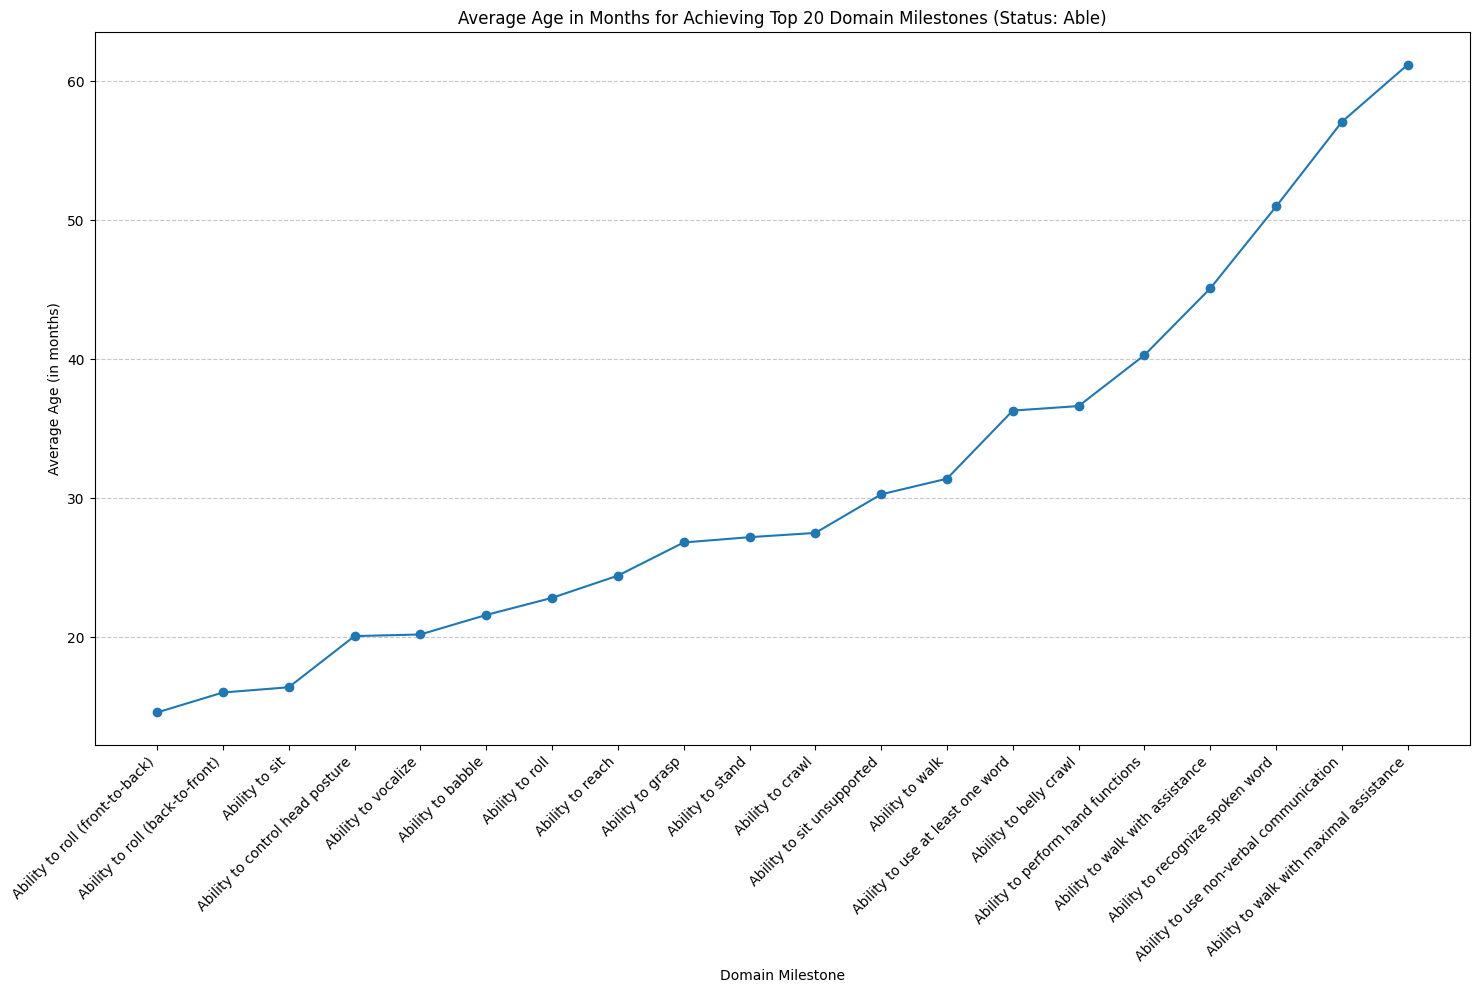

In [18]:
import matplotlib.pyplot as plt

# I'm assuming that 'domain_age_days_firstDate' is the column representing the age in days at which the milestone was first achieved
# Here, we convert age in days to age in months
development_df['avg_age_months'] = development_df['domain_age_days_firstDate'] / 30.44

plt.figure(figsize=(15, 10))

# Continue with the existing filtering
able_df = development_df[development_df['domain_status'] == 'Able']
top_milestones = able_df['domain_milestone'].value_counts().head(20).index.tolist()
filtered_able_df = able_df[able_df['domain_milestone'].isin(top_milestones)]

# Now you can calculate the average ages
average_ages = filtered_able_df.groupby('domain_milestone')['avg_age_months'].mean().sort_values()

# Continue with the plotting
plt.plot(average_ages.index, average_ages.values, marker='o', linestyle='-')
plt.title('Average Age in Months for Achieving Top 20 Domain Milestones (Status: Able)')
plt.xlabel('Domain Milestone')
plt.ylabel('Average Age (in months)')
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()


/tmp/ipykernel_114/2127553948.py:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


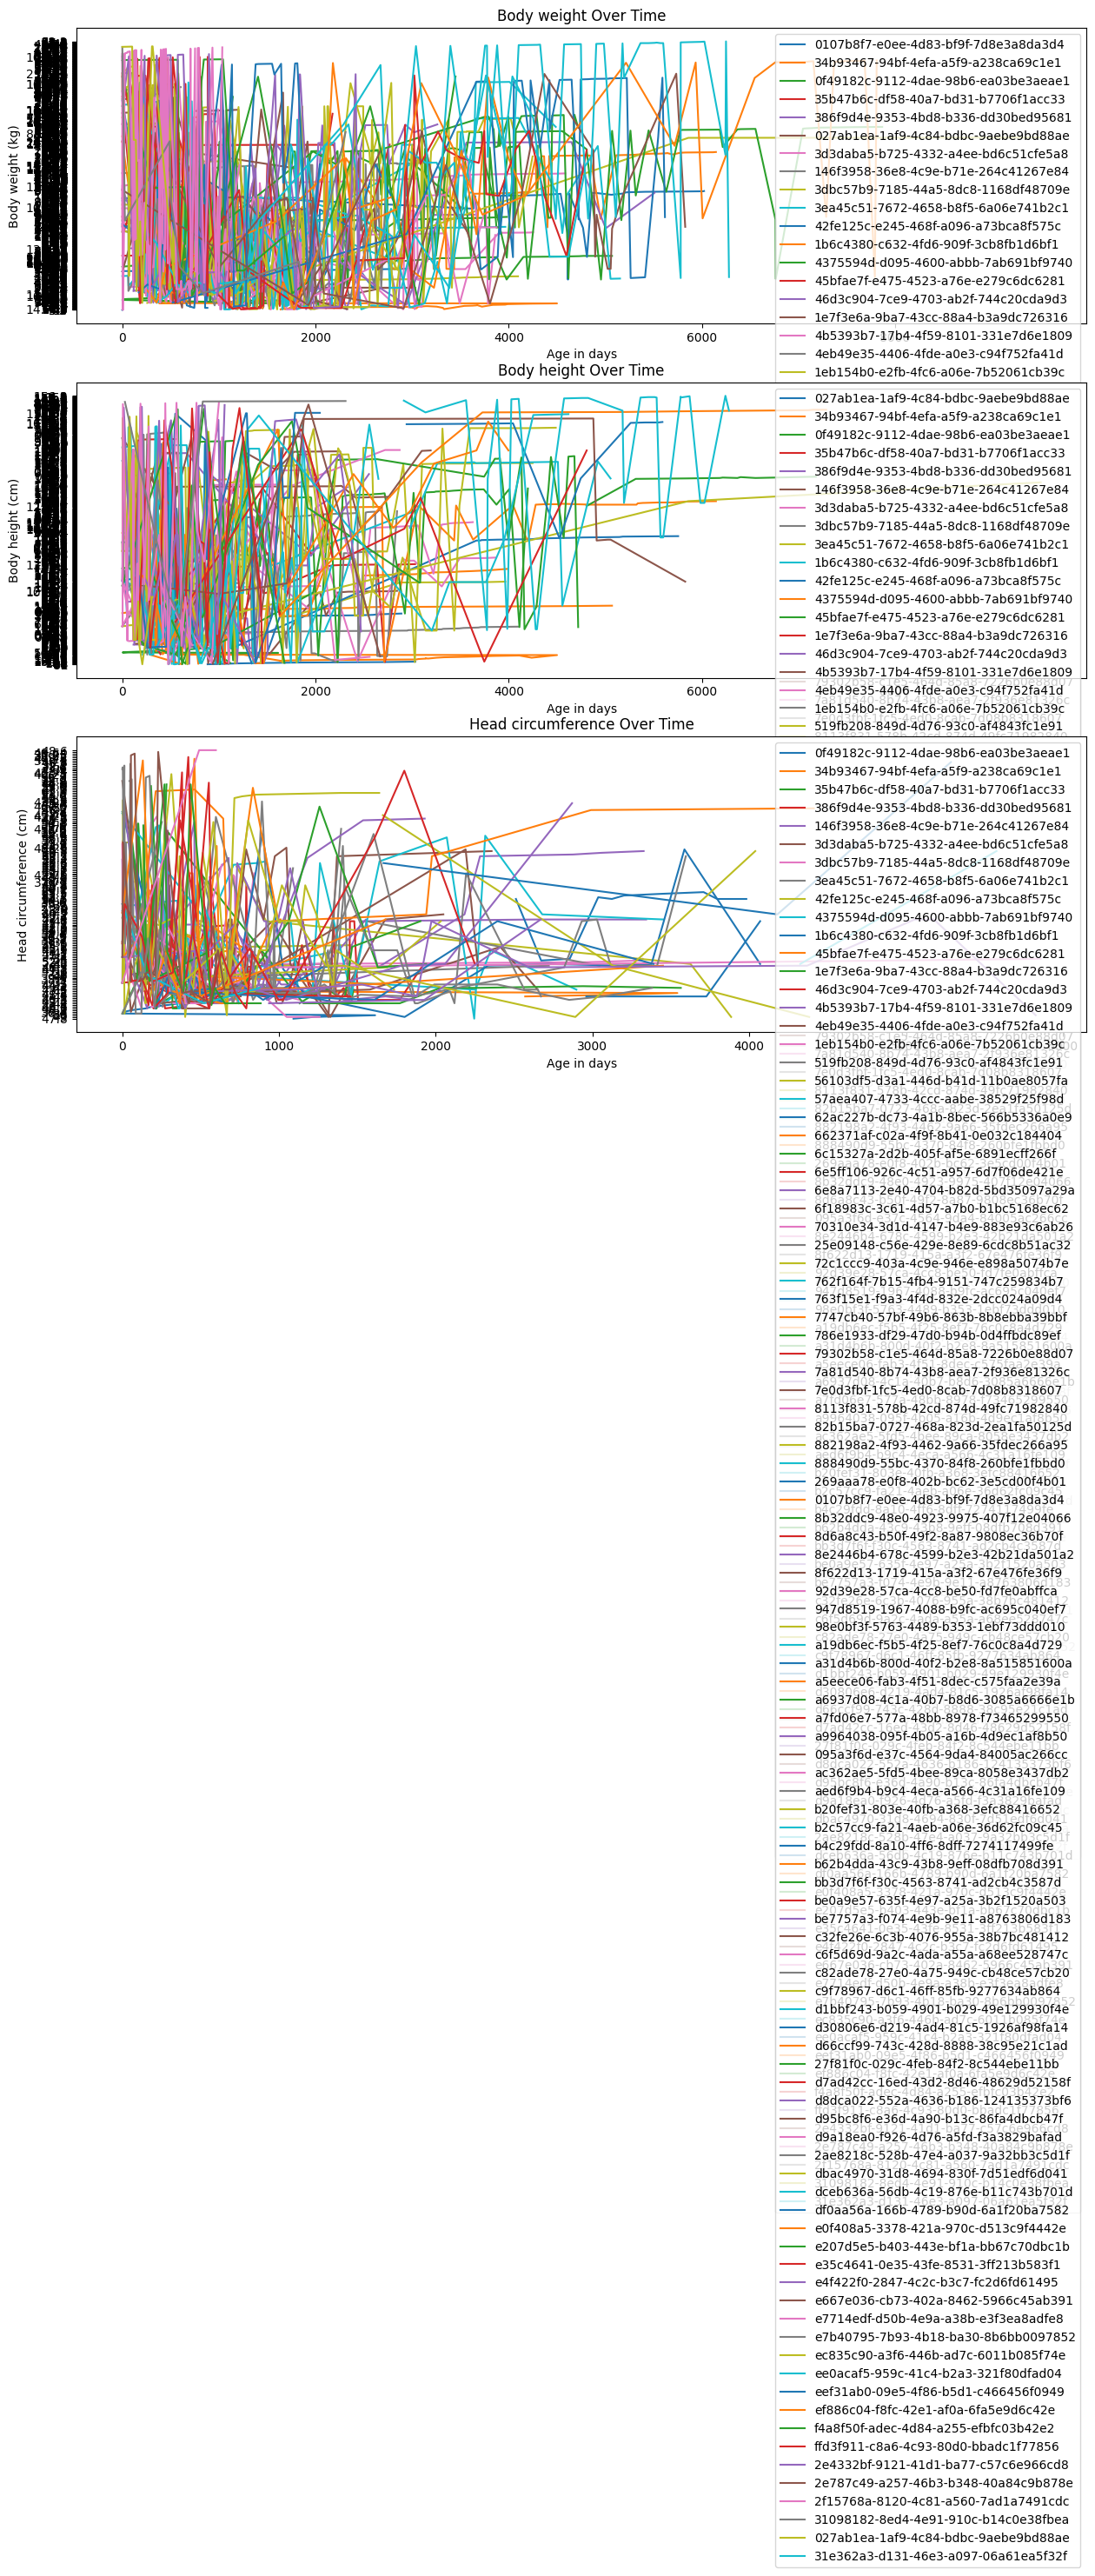

In [19]:
import pandas as pd


growth_df = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "growth_parameters", model = "flexible").text), sep='\t')

import pandas as pd
import matplotlib.pyplot as plt

# Convert weights from grams to kilograms for rows with growth_parameter_unit as 'g'
mask_weight = (growth_df['growth_parameter'] == 'weight') & (growth_df['growth_parameter_unit'] == 'g')
growth_df.loc[mask_weight, 'growth_parameter_value'] = growth_df.loc[mask_weight, 'growth_parameter_value'] / 1000
growth_df.loc[mask_weight, 'growth_parameter_unit'] = 'kg'

# Convert heights from meters to centimeters for rows with growth_parameter_unit as 'm'
mask_height = (growth_df['growth_parameter'] == 'height') & (growth_df['growth_parameter_unit'] == 'm')
growth_df.loc[mask_height, 'growth_parameter_value'] = growth_df.loc[mask_height, 'growth_parameter_value'] * 100
growth_df.loc[mask_height, 'growth_parameter_unit'] = 'cm'



# List of growth parameters
parameters = ['Body weight', 'Body height', 'Head circumference']

# Set up the plotting canvas
fig, axes = plt.subplots(nrows=len(parameters), figsize=(15, 15))

# Plot each parameter
for index, param in enumerate(parameters):
    subset = growth_df[growth_df['growth_parameter'] == param]
    for patient in subset['patient_uuid'].unique():
        patient_data = subset[subset['patient_uuid'] == patient]
        axes[index].plot(patient_data['growth_parameter_age_days'], patient_data['growth_parameter_value'], label=patient)
    axes[index].set_title(f'{param.capitalize()} Over Time')
    axes[index].set_xlabel('Age in days')
    axes[index].set_ylabel(f'{param.capitalize()} ({subset["growth_parameter_unit"].iloc[0]})')
    axes[index].legend()

plt.tight_layout()
plt.show()





1. **Scatter Plot**: The individual blue dots represent the actual data points in your dataset. Each dot corresponds to a measurement of body weight (on the y-axis) taken at a certain age in days (on the x-axis) for a particular patient.

2. **KDE Plot**: The shaded regions, ranging from dark blue to light blue, represent the density of data points. The KDE plot is essentially a smoothed histogram that estimates the probability density function of the variable.

    - **Dark Blue Regions**: Areas where data points are densely packed. The darkest blue regions indicate where the majority of the measurements lie for a given age in days.
  
    - **Light Blue Regions**: As the shade becomes lighter, it indicates fewer data points in that region. The lightest regions show areas where there are very few measurements.

3. **Color Bar**: On the right side, you see a vertical color bar. This is a legend for the KDE plot that provides a visual cue for the data density. The darker the shade of blue, the higher the density of data points.

In summary:

- The graph gives an overview of how body weight changes over time (from 0 to 10,000 days) for the patients in your dataset.
- The densely packed dark blue regions show the most common weight ranges for given ages.
- The scatter points provide individual data points, while the shaded KDE regions give you a sense of the overall trend and distribution.

By using this combined approach, you can both see individual measurements and get an understanding of the overall trend and distribution of body weight over age in days.

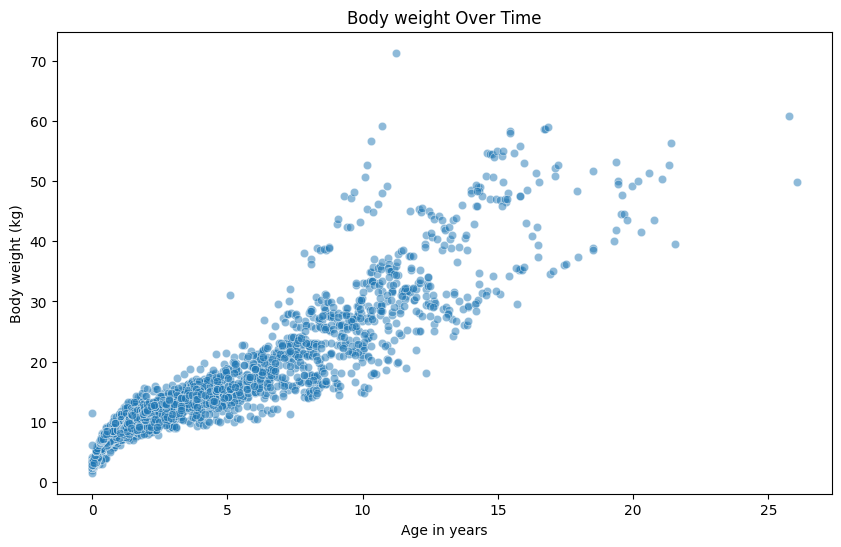

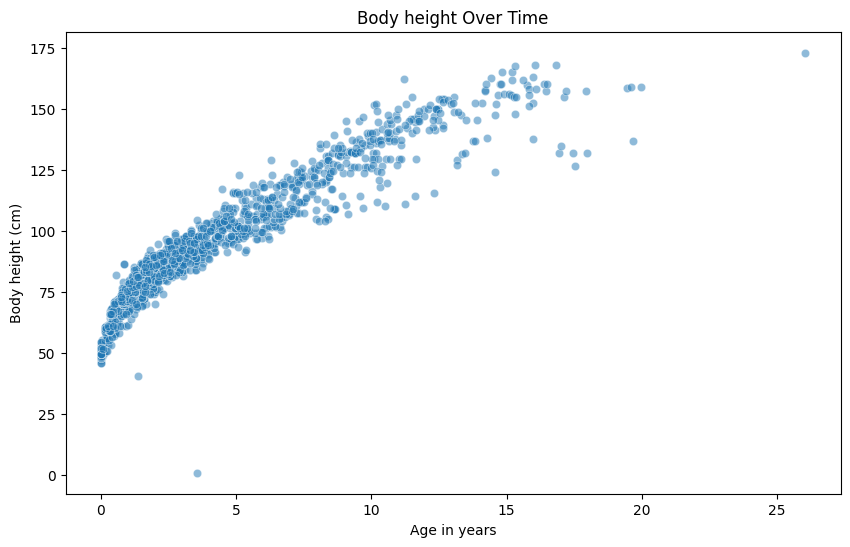

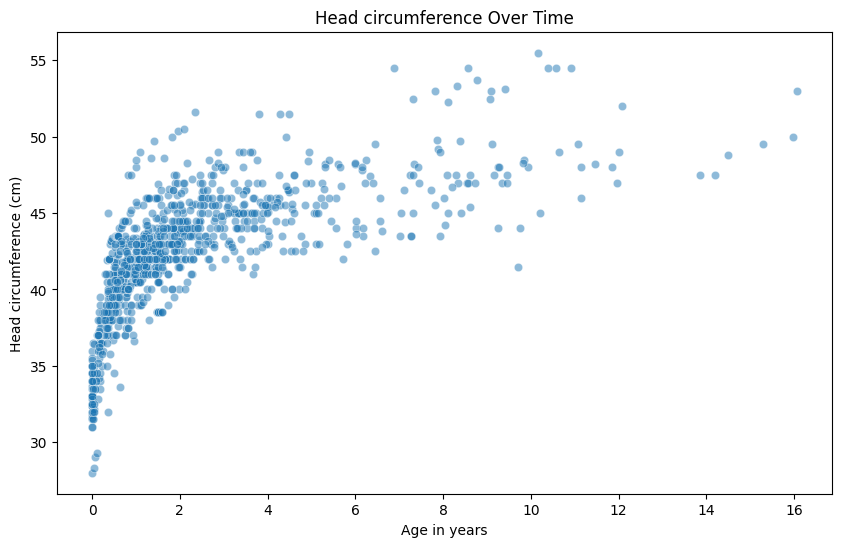

entity:growth_parameters_id    growth_parameter  \
2407                         3165         Body height   
2330                         3096         Body weight   
991                          1891         Body height   
4671                         5202         Body weight   
3239                         3914  Head circumference   

      growth_parameter_age_days growth_parameter_code  \
2407                        770                8302-2   
2330                       5509               29463-7   
991                        3858                8302-2   
4671                       2399               29463-7   
3239                       1046                8287-5   

     growth_parameter_code_system growth_parameter_date growth_parameter_unit  \
2407                        LOINC               10/8/19                    cm   
2330                        LOINC               2/20/19                    kg   
991                         LOINC               5/13/19                    cm   
4671                        LOINC               8/30/05                    kg   
3239                        LOINC               2/20/15                    cm   

      growth_parameter_value                          patient_uuid  \
2407                    80.0  8f622d13-1719-415a-a3f2-67e476fe36f9   
2330                    31.3  8b32ddc9-48e0-4923-9975-407f12e04066   
991                    143.6  62ac227b-dc73-4a1b-8bec-566b5336a0e9   
4671                    15.8  eef31ab0-09e5-4f86-b5d1-c466456f0949   
3239                    45.5  be7757a3-f074-4e9b-9e11-a8763806d183   

      growth_parameter_age_years  
2407                    2.109589  
2330                   15.093151  
991                    10.569863  
4671                    6.572603  
3239                    2.865753

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
growth_df = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "growth_parameters", model = "flexible").text), sep='\t')
df = growth_df

# Assuming the data is loaded into df

# Convert growth_parameter_value to numeric
df['growth_parameter_value'] = pd.to_numeric(df['growth_parameter_value'], errors='coerce')

# Normalize units for weight (from 'g' to 'kg')
df.loc[df['growth_parameter_unit'] == 'g', 'growth_parameter_value'] /= 1000
df.loc[df['growth_parameter_unit'] == 'g', 'growth_parameter_unit'] = 'kg'

# Normalize units for height (from 'm' to 'cm')
df.loc[df['growth_parameter_unit'] == 'm', 'growth_parameter_value'] *= 100
df.loc[df['growth_parameter_unit'] == 'm', 'growth_parameter_unit'] = 'cm'

# Now, plot for each growth parameter
growth_parameters_list = ['Body weight', 'Body height', 'Head circumference']

df['growth_parameter_age_years'] = df['growth_parameter_age_days'] / 365


for param in growth_parameters_list:
    subset_df = df[df['growth_parameter'] == param]
    
    plt.figure(figsize=(10, 6))
    
    # Scatter plot with actual data points
    sns.scatterplot(x='growth_parameter_age_years', y='growth_parameter_value', data=subset_df, alpha=0.5)
    
    # Polynomial regression curve of order 2
    #sns.regplot(x='growth_parameter_age_years', y='growth_parameter_value', data=df[df['growth_parameter'] == param], scatter=False, color='blue', line_kws={"color": "blue"}, order=2)
    
    plt.title(f'{param.capitalize()} Over Time')
    plt.xlabel('Age in years')
    plt.ylabel(f'{param.capitalize()} ({subset_df["growth_parameter_unit"].iloc[0]})')
    plt.show()
    
df.sample(5)



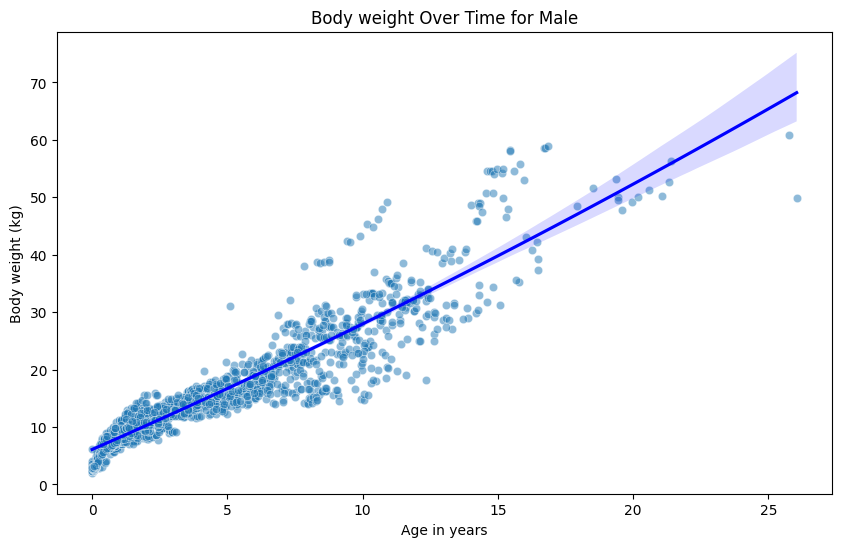

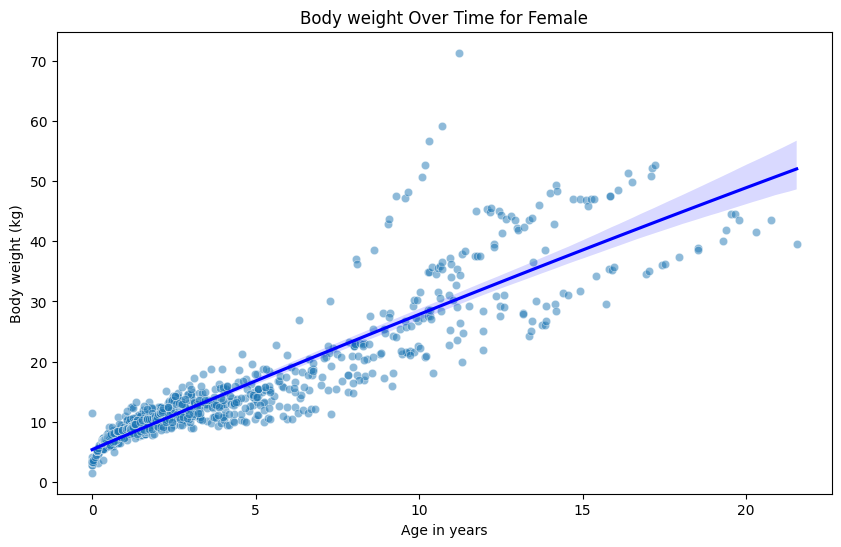

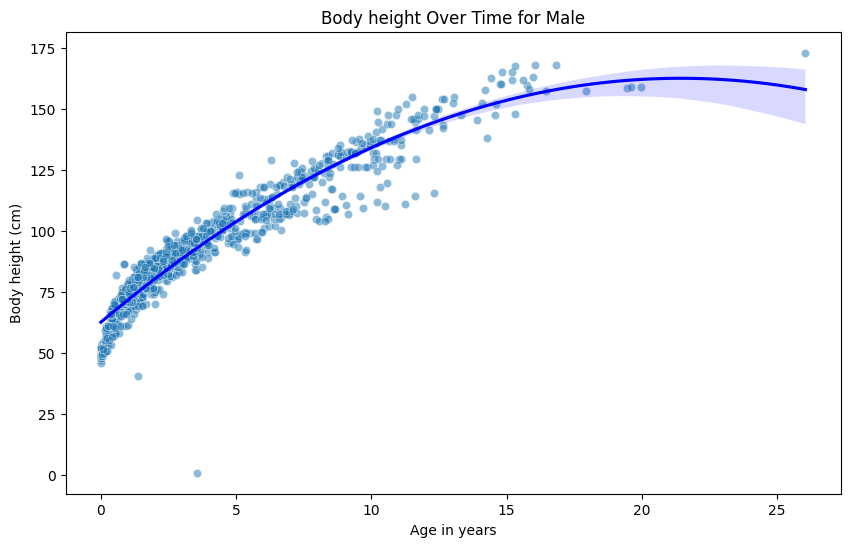

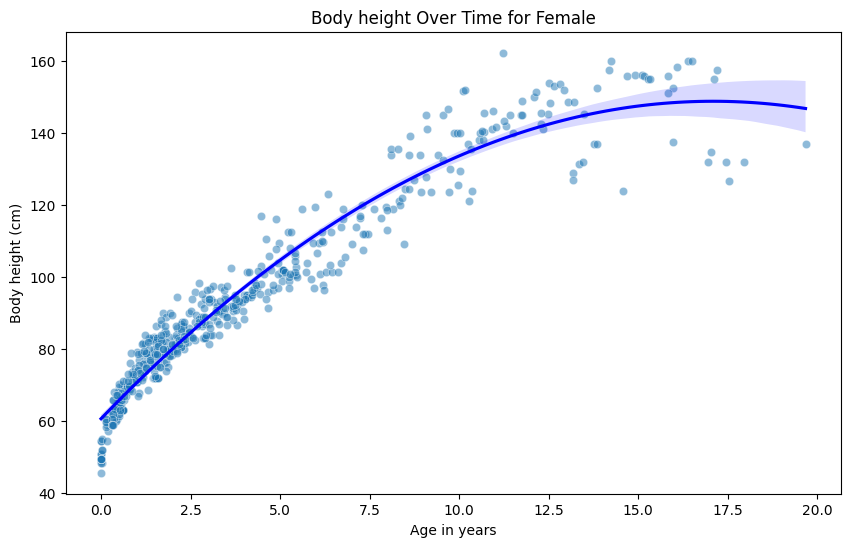

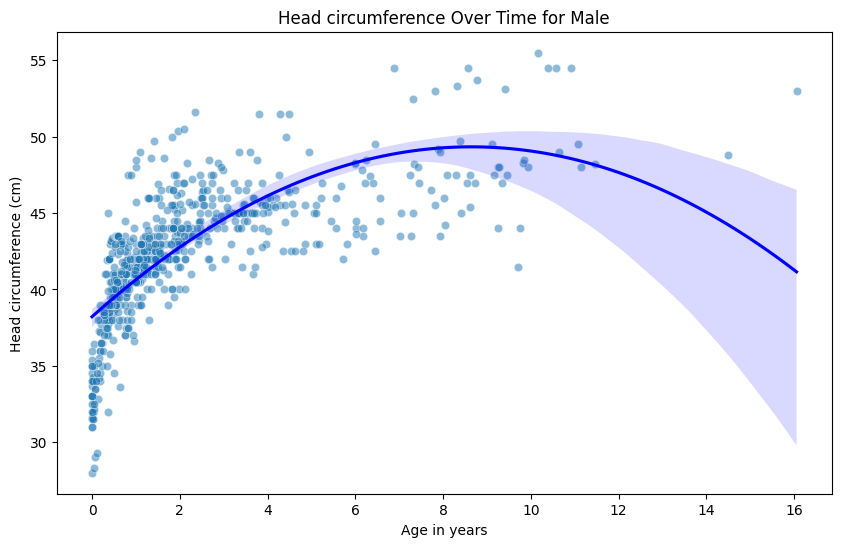

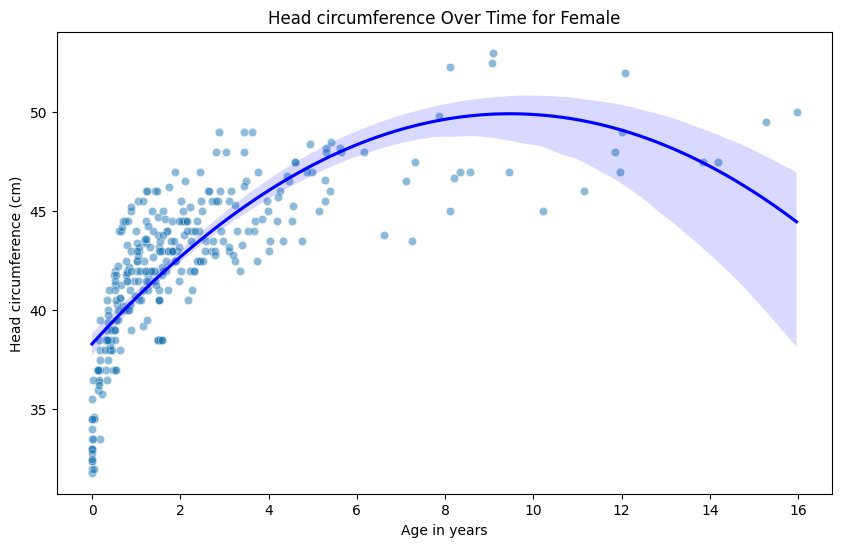

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
growth_df = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "growth_parameters", model = "flexible").text), sep='\t')

df = growth_df
patient_table = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "patient_uuid", model = "flexible").text), sep='\t')
patient_table.rename(columns = {'entity:patient_uuid_id':'patient_uuid'}, inplace = True)

# Assuming df and patient_table are already loaded

# Merge patient_table with df to get the gender information
df = df.merge(patient_table[['patient_uuid', 'sex']], on='patient_uuid')

# Convert growth_parameter_value to numeric
df['growth_parameter_value'] = pd.to_numeric(df['growth_parameter_value'], errors='coerce')

# Normalize units for weight (from 'g' to 'kg')
df.loc[df['growth_parameter_unit'] == 'g', 'growth_parameter_value'] /= 1000
df.loc[df['growth_parameter_unit'] == 'g', 'growth_parameter_unit'] = 'kg'

# Normalize units for height (from 'm' to 'cm')
df.loc[df['growth_parameter_unit'] == 'm', 'growth_parameter_value'] *= 100
df.loc[df['growth_parameter_unit'] == 'm', 'growth_parameter_unit'] = 'cm'

# Define the growth parameters and genders
growth_parameters_list = ['Body weight', 'Body height', 'Head circumference']
genders = ['male', 'female']

df['growth_parameter_age_years'] = df['growth_parameter_age_days'] / 365

for param in growth_parameters_list:
    for gender in genders:
        subset_df = df[(df['growth_parameter'] == param) & (df['sex'] == gender)]
        
        if not subset_df.empty:  # Check if the subset is not empty
            plt.figure(figsize=(10, 6))
            
            # Scatter plot with actual data points
            sns.scatterplot(x='growth_parameter_age_years', y='growth_parameter_value', data=subset_df, alpha=0.5)
            
            # Polynomial regression line (e.g., quadratic)
            sns.regplot(x='growth_parameter_age_years', y='growth_parameter_value', data=subset_df, scatter=False, color='blue', line_kws={"color": "blue"}, order=2)
            
            # Add title and labels
            plt.title(f'{param.capitalize()} Over Time for {gender.capitalize()}')
            plt.xlabel('Age in years')
            plt.ylabel(f'{param.capitalize()} ({subset_df["growth_parameter_unit"].iloc[0]})')
            plt.show()







    
    

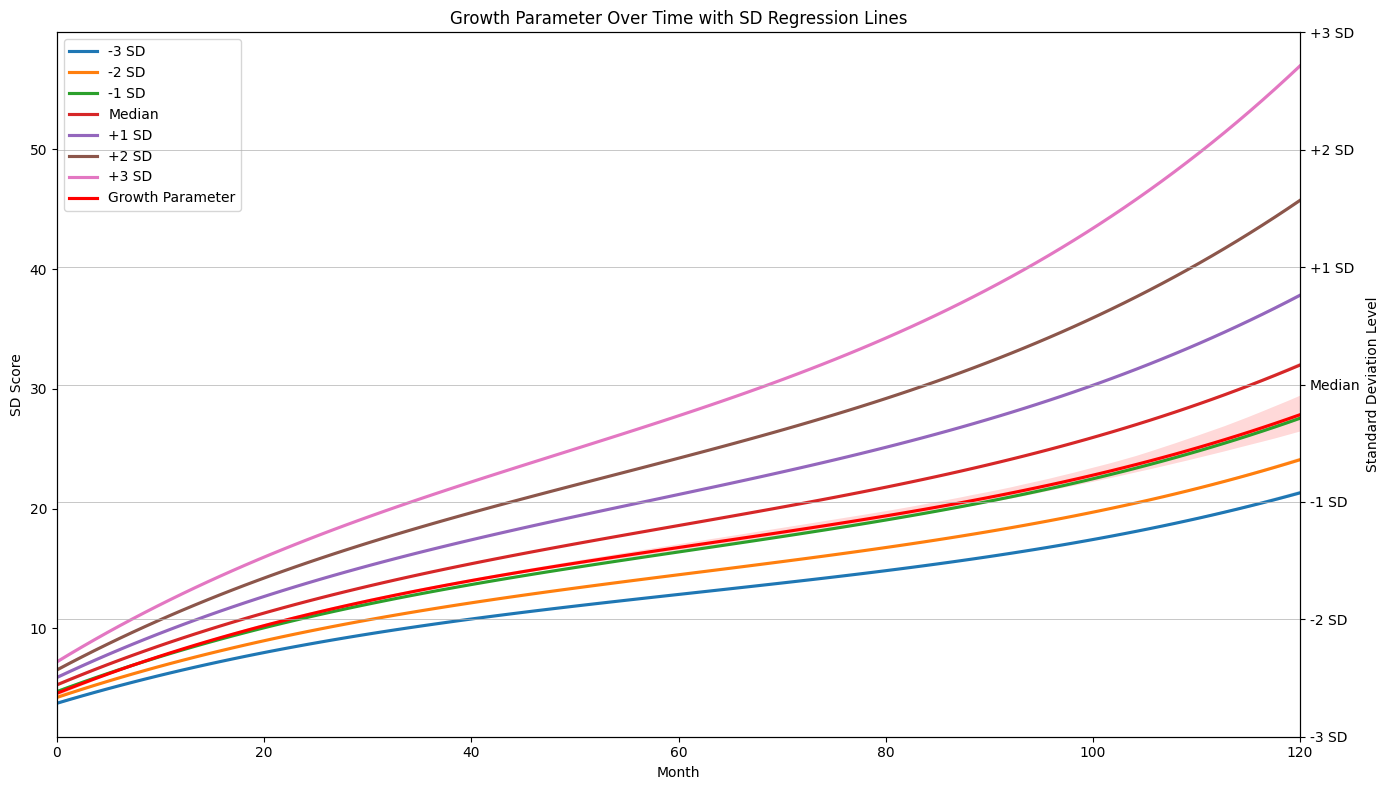

In [73]:
###### Purpose of this cell is to calculate z-scores for patients by referring to WHO z-scores values
###### for growth parameters of males and females. After that, plot those values against mean z-score
###### values over time.

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
growth_df = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "growth_parameters", model = "flexible").text), sep='\t')
df = growth_df
patient_table = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "patient_uuid", model = "flexible").text), sep='\t')
patient_table.rename(columns = {'entity:patient_uuid_id':'patient_uuid'}, inplace = True)






# Assuming df and patient_table are already loaded

# Merge patient_table with df to get the gender information
df = df.merge(patient_table[['patient_uuid', 'sex']], on='patient_uuid')

# Convert growth_parameter_value to numeric
df['growth_parameter_value'] = pd.to_numeric(df['growth_parameter_value'], errors='coerce')

# Normalize units for weight (from 'g' to 'kg')
df.loc[df['growth_parameter_unit'] == 'g', 'growth_parameter_value'] /= 1000
df.loc[df['growth_parameter_unit'] == 'g', 'growth_parameter_unit'] = 'kg'

# Normalize units for height (from 'm' to 'cm')
df.loc[df['growth_parameter_unit'] == 'm', 'growth_parameter_value'] *= 100
df.loc[df['growth_parameter_unit'] == 'm', 'growth_parameter_unit'] = 'cm'

# Define the growth parameters and genders
growth_parameters_list = ['Body weight', 'Body height', 'Head circumference']
genders = ['male', 'female']

df['growth_parameter_age_years'] = df['growth_parameter_age_days'] / 365
df['growth_parameter_age_month'] = df['growth_parameter_age_days'] / 30.44
df['Month'] = round(df['growth_parameter_age_month'])

df['Month'] = df['Month'].apply(lambda x: round(x))


## split df by sex

male_df = df[df['sex'] == 'male']
female_df = df[df['sex'] == 'female']


#split each sex df further by growth parameters

male_head_circumference_df = male_df[male_df['growth_parameter'] == 'Head circumference']
female_head_circumference_df = female_df[female_df['growth_parameter'] == 'Head circumference']
male_body_weight_df = male_df[male_df['growth_parameter'] == 'Body weight']
female_body_weight_df = female_df[female_df['growth_parameter'] == 'Body weight']
male_body_height_df = male_df[male_df['growth_parameter'] == 'Body height']
female_body_height_df = female_df[female_df['growth_parameter'] == 'Body height']



############ Read all WHO files

who_male_head_circumference_df = pd.read_csv ('head-circumference-boys-0-5-month-boys.csv')
who_female_head_circumference_df = pd.read_csv ('head-circumference-boys-0-5-month-girls.csv')
who_male_body_weight_df = pd.read_csv ('body-weight-0-10-month-boys.csv')
who_female_body_weight_df = pd.read_csv ('body-weight-0-10-month-girls.csv')
who_male_body_height_df = pd.read_csv ('body-height-0-19-month-boys.csv')
who_female_body_height_df = pd.read_csv ('body-height-0-19-month-girls.csv')


## height table does not have standard deviation, so lets compute that

who_male_body_weight_df['SD'] = who_male_body_weight_df['M'] * who_male_body_weight_df['S']
who_female_body_weight_df['SD'] = who_female_body_weight_df['M'] * who_female_body_weight_df['S']



##### Merge dataframes with WHO dataframes with zscores on Month


male_head_circumference_zscore_df = pd.merge(male_head_circumference_df, who_male_head_circumference_df, on='Month')
female_head_circumference_zscore_df = pd.merge(female_head_circumference_df, who_female_head_circumference_df, on='Month')
male_body_weight_zscore_df = pd.merge(male_body_weight_df, who_male_body_weight_df, on='Month')
female_body_weight_zscore_df = pd.merge(female_body_weight_df, who_female_body_weight_df, on='Month')
male_body_height_zscore_df = pd.merge(male_body_height_df, who_male_body_height_df, on='Month')
female_body_height_zscore_df = pd.merge(female_body_height_df, who_female_body_height_df, on='Month')



# Calculate Z-Scores
male_head_circumference_zscore_df['zscore'] = (male_head_circumference_zscore_df['growth_parameter_value'] - male_head_circumference_zscore_df['M']) / male_head_circumference_zscore_df['SD']
female_head_circumference_zscore_df['zscore'] = (female_head_circumference_zscore_df['growth_parameter_value'] - female_head_circumference_zscore_df['M']) / female_head_circumference_zscore_df['SD']
male_body_weight_zscore_df['zscore'] = (male_body_weight_zscore_df['growth_parameter_value'] - male_body_weight_zscore_df['M']) / male_body_weight_zscore_df['SD']
female_body_weight_zscore_df['zscore'] = (female_body_weight_zscore_df['growth_parameter_value'] - female_body_weight_zscore_df['M']) / female_body_weight_zscore_df['SD']
male_body_height_zscore_df['zscore'] = (male_body_height_zscore_df['growth_parameter_value'] - male_body_height_zscore_df['M']) / male_body_height_zscore_df['SD']
female_body_height_zscore_df['zscore'] = (female_body_height_zscore_df['growth_parameter_value'] - female_body_height_zscore_df['M']) / female_body_height_zscore_df['SD']



# Calcualte Z-Scores using LMS model
# reference : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7849193/#:~:text=Z%20score%20was%20calculated%20from,0%20(18%E2%80%9320).
# reference : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4991205/
def calculate_z_score(growth_parameter_value, L, M, S):
        return ((growth_parameter_value / M) ** L - 1) / (L * S)
    
male_head_circumference_zscore_df['z_score'] = male_head_circumference_zscore_df.apply(lambda x: calculate_z_score(x['growth_parameter_value'], x['L'], x['M'], x['S']), axis=1)
female_head_circumference_zscore_df['z_score'] = female_head_circumference_zscore_df.apply(lambda x: calculate_z_score(x['growth_parameter_value'], x['L'], x['M'], x['S']), axis=1)
male_body_weight_zscore_df['z_score'] = male_body_weight_zscore_df.apply(lambda x: calculate_z_score(x['growth_parameter_value'], x['L'], x['M'], x['S']), axis=1)
female_body_weight_zscore_df['z_score'] = female_body_weight_zscore_df.apply(lambda x: calculate_z_score(x['growth_parameter_value'], x['L'], x['M'], x['S']), axis=1)
male_body_height_zscore_df['z_score'] = male_body_height_zscore_df.apply(lambda x: calculate_z_score(x['growth_parameter_value'], x['L'], x['M'], x['S']), axis=1)
female_body_height_zscore_df['z_score'] = female_body_height_zscore_df.apply(lambda x: calculate_z_score(x['growth_parameter_value'], x['L'], x['M'], x['S']), axis=1)



pd.set_option('display.max_columns', None)

df = male_body_weight_zscore_df


import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(14, 8))

# Plot polynomial regression for each SD value
for sd, label in zip(sd_columns, labels):
    sns.regplot(x='Month', y=sd, data=df, order=3, scatter=False, label=label)

# Polynomial regression for the growth parameter value
sns.regplot(x='Month', y='growth_parameter_value', data=df, order=3, scatter=False, color='red', label='Growth Parameter')

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('SD Score')
plt.title('Growth Parameter Over Time with SD Regression Lines')

# Set x-axis and y-axis limits
plt.xlim(df['Month'].min(), df['Month'].max())

# Display the legend
plt.legend()

# Set y-axis labels on the right side
ax = plt.gca()
ax2 = ax.twinx()
ax2.set_ylabel('Standard Deviation Level')
ax2.set_ylim(-3, 3)
ax2.set_yticks(np.arange(-3, 4, 1))
ax2.set_yticklabels(['-3 SD', '-2 SD', '-1 SD', 'Median', '+1 SD', '+2 SD', '+3 SD'])

# Add both vertical and horizontal grid lines
plt.grid(True, which='both', linestyle='-', linewidth=0.5)

# Show the plot with a tight layout
plt.tight_layout()
plt.show()




    
    








/tmp/ipykernel_114/1512859720.py:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=subset_df['growth_parameter_age_years'], y=subset_df['growth_parameter_value'], cmap="Blues", shade=True, cbar=True)


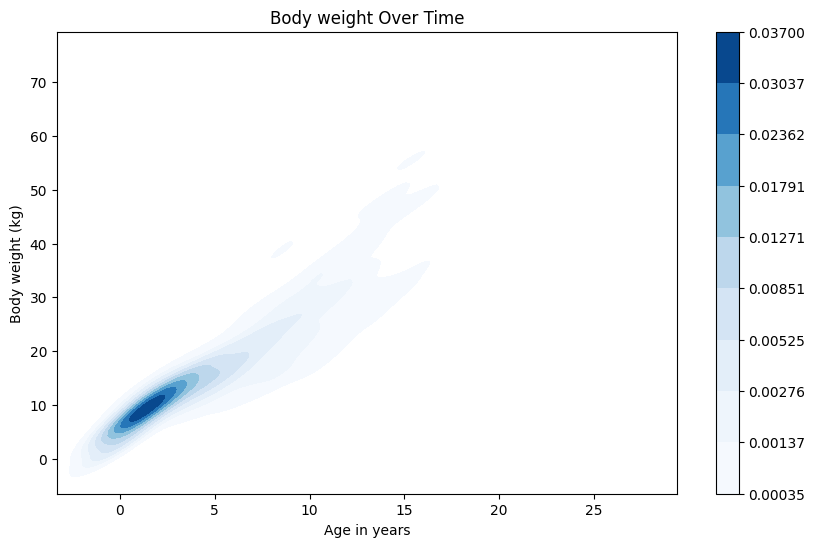

/tmp/ipykernel_114/1512859720.py:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=subset_df['growth_parameter_age_years'], y=subset_df['growth_parameter_value'], cmap="Blues", shade=True, cbar=True)


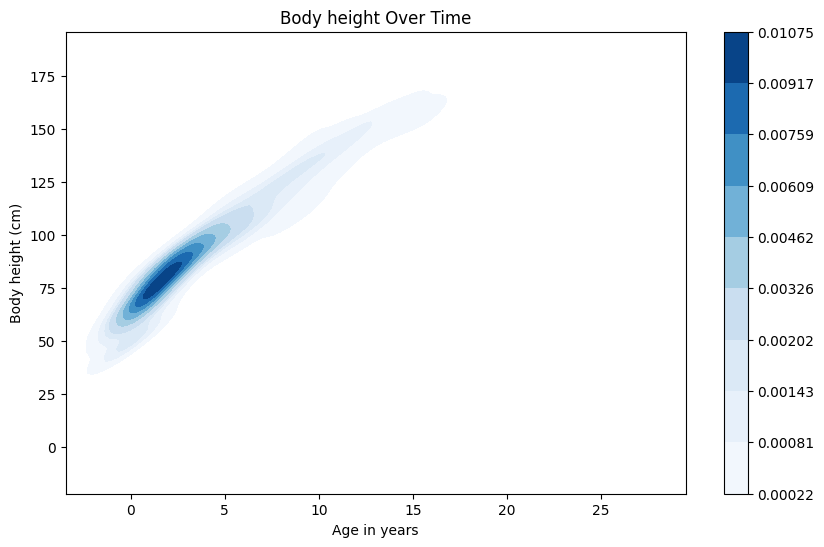

/tmp/ipykernel_114/1512859720.py:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=subset_df['growth_parameter_age_years'], y=subset_df['growth_parameter_value'], cmap="Blues", shade=True, cbar=True)


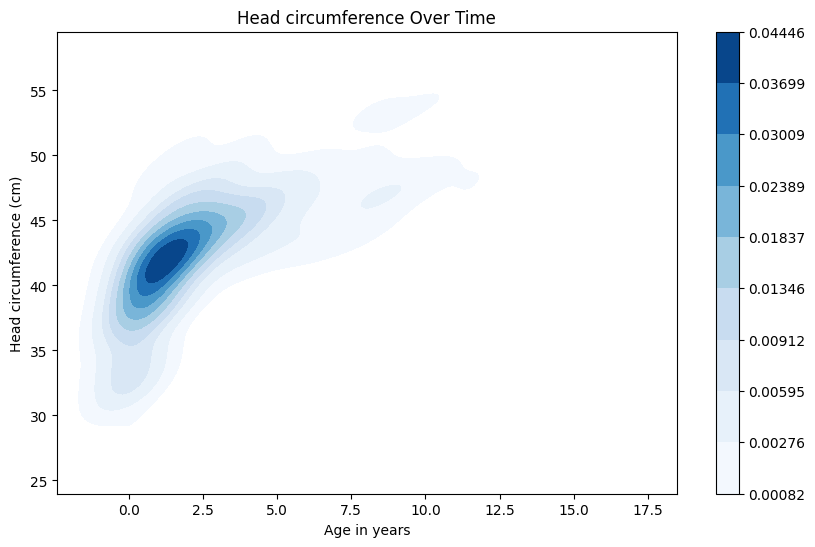

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = growth_df

# Assuming the data is loaded into df

# Convert growth_parameter_value to numeric
df['growth_parameter_value'] = pd.to_numeric(df['growth_parameter_value'], errors='coerce')

# Normalize units for weight (from 'g' to 'kg')
df.loc[df['growth_parameter_unit'] == 'g', 'growth_parameter_value'] /= 1000
df.loc[df['growth_parameter_unit'] == 'g', 'growth_parameter_unit'] = 'kg'

# Normalize units for height (from 'm' to 'cm')
df.loc[df['growth_parameter_unit'] == 'm', 'growth_parameter_value'] *= 100
df.loc[df['growth_parameter_unit'] == 'm', 'growth_parameter_unit'] = 'cm'

# Now, plot for each growth parameter
growth_parameters_list = ['Body weight', 'Body height', 'Head circumference']

# df['growth_parameter_age_months'] = df['growth_parameter_age_days'] / 30.44
df['growth_parameter_age_years'] = df['growth_parameter_age_days'] / 365


for param in growth_parameters_list:
    subset_df = df[df['growth_parameter'] == param]
    
    plt.figure(figsize=(10, 6))
    
    # Density heatmap
    sns.kdeplot(x=subset_df['growth_parameter_age_years'], y=subset_df['growth_parameter_value'], cmap="Blues", shade=True, cbar=True)
    
    
    
    plt.title(f'{param.capitalize()} Over Time')
    plt.xlabel('Age in years')
    plt.ylabel(f'{param.capitalize()} ({subset_df["growth_parameter_unit"].iloc[0]})')
    plt.show()


## Chorea  

Plot Chorea exam findings relationships

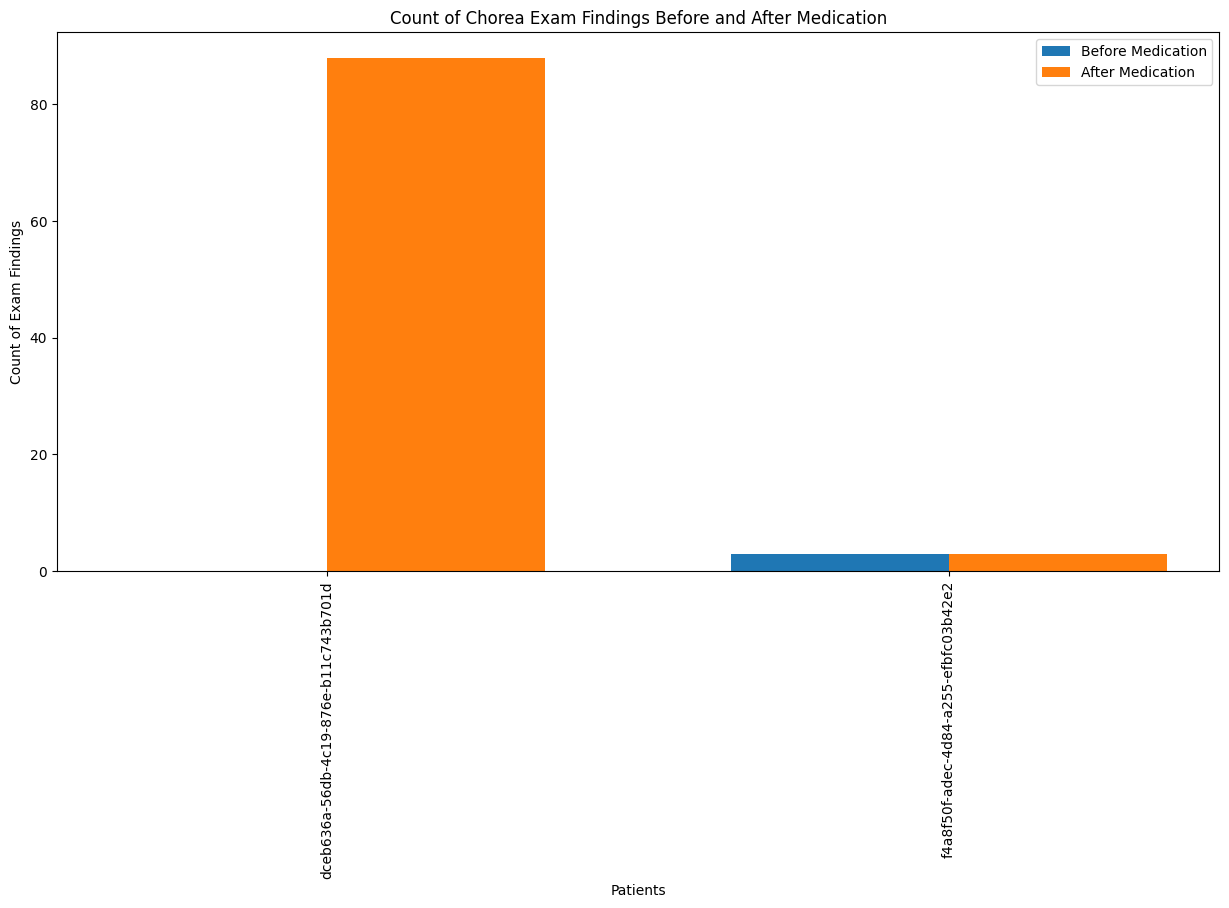

In [24]:
import pandas as pd

# Load the datasets
medications_df = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "medication", model = "flexible").text), sep='\t')
clinical_diagnosis_df = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "clinical_diagnosis", model = "flexible").text), sep='\t')
exam_findings_df = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "exam_findings", model = "flexible").text), sep='\t')


# Filter for 'chorea' in each dataset
medications_chorea = medications_df[medications_df['medication_indication'].str.lower() == 'chorea']
clinical_chorea = clinical_diagnosis_df[clinical_diagnosis_df['clinical_diagnosis'].str.lower() == 'chorea']
exam_chorea = exam_findings_df[exam_findings_df['exam_finding'].str.lower() == 'chorea']

# Merge datasets on 'patient_uuid'
merged_df = pd.merge(medications_chorea, clinical_chorea, on='patient_uuid', suffixes=('_med', '_diag'))
merged_df = pd.merge(merged_df, exam_chorea, on='patient_uuid')

import matplotlib.pyplot as plt

# Assuming merged_df is already created and contains the necessary information from the previous step

# Initialize a dictionary to store the count of exam findings before and after medication for each patient
findings_count = {}

for uuid in merged_df['patient_uuid'].unique():
    patient_data = merged_df[merged_df['patient_uuid'] == uuid]
    
    # Get the age in days when medication started
    med_start_age = patient_data['medication_age_days_firstDate'].min()
    
    # Count exam findings before and after medication start
    count_before_med = patient_data[patient_data['exam_age_days'] < med_start_age]['exam_finding'].count()
    count_after_med = patient_data[patient_data['exam_age_days'] >= med_start_age]['exam_finding'].count()
    
    findings_count[uuid] = {'before_med': count_before_med, 'after_med': count_after_med}

# Now, create a DataFrame from the dictionary for easier plotting
findings_df = pd.DataFrame.from_dict(findings_count, orient='index')

# Plotting
fig, ax = plt.subplots(figsize=(15, 7))

# Creating indices for each pair of 'before' and 'after' medication bars
ind = range(len(findings_df))

# Bar width
bar_width = 0.35

# Plotting 'before medication' counts
ax.bar(ind, findings_df['before_med'], bar_width, label='Before Medication')

# Plotting 'after medication' counts
ax.bar([i + bar_width for i in ind], findings_df['after_med'], bar_width, label='After Medication')

# Labels and title
ax.set_xlabel('Patients')
ax.set_ylabel('Count of Exam Findings')
ax.set_title('Count of Chorea Exam Findings Before and After Medication')
ax.set_xticks([i + bar_width / 2 for i in ind])
ax.set_xticklabels(findings_df.index)
ax.legend()

# Rotate x-axis labels for better readability if there are many patients
plt.xticks(rotation=90)

plt.show()

    

## Observe exam findings trend

/tmp/ipykernel_114/3297349118.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chorea_df['exam_age_days'] = pd.to_numeric(chorea_df['exam_age_days'], errors='coerce')
/tmp/ipykernel_114/3297349118.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chorea_df['exam_age_years'] = chorea_df['exam_age_days'] / 365.25


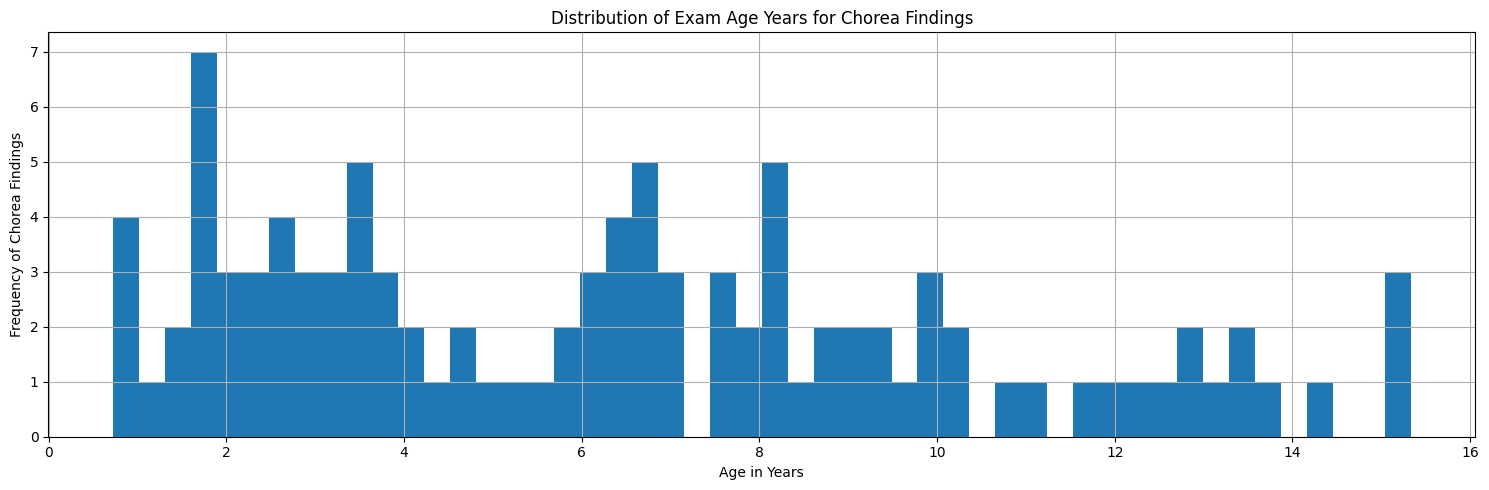

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data (assuming 'exam_findings.csv' is the path to your file)
exam_df = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "exam_findings", model = "flexible").text), sep='\t')



# Filter rows where 'exam_finding' contains 'chorea'
chorea_df = exam_df[exam_df['exam_finding'].str.contains('chorea', case=False, na=False)]

# Convert 'exam_age_days' to numeric if it's not already
chorea_df['exam_age_days'] = pd.to_numeric(chorea_df['exam_age_days'], errors='coerce')

# Convert 'exam_age_days' to 'exam_age_years'
chorea_df['exam_age_years'] = chorea_df['exam_age_days'] / 365.25

# Plotting a histogram of 'exam_age_years' for chorea findings
plt.figure(figsize=(15, 5))
chorea_df['exam_age_years'].hist(bins=50)

plt.title('Distribution of Exam Age Years for Chorea Findings')
plt.xlabel('Age in Years')
plt.ylabel('Frequency of Chorea Findings')
plt.grid(True)
plt.tight_layout()
plt.show()



/tmp/ipykernel_88/1771508382.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meds_patient['medication_age_years_firstDate'] = meds_patient['medication_age_days_firstDate'] / 365.25
/tmp/ipykernel_88/1771508382.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meds_patient['medication_age_years_lastDate'] = meds_patient['medication_age_days_lastDate'] / 365.25
/tmp/ipykernel_88/1771508382.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

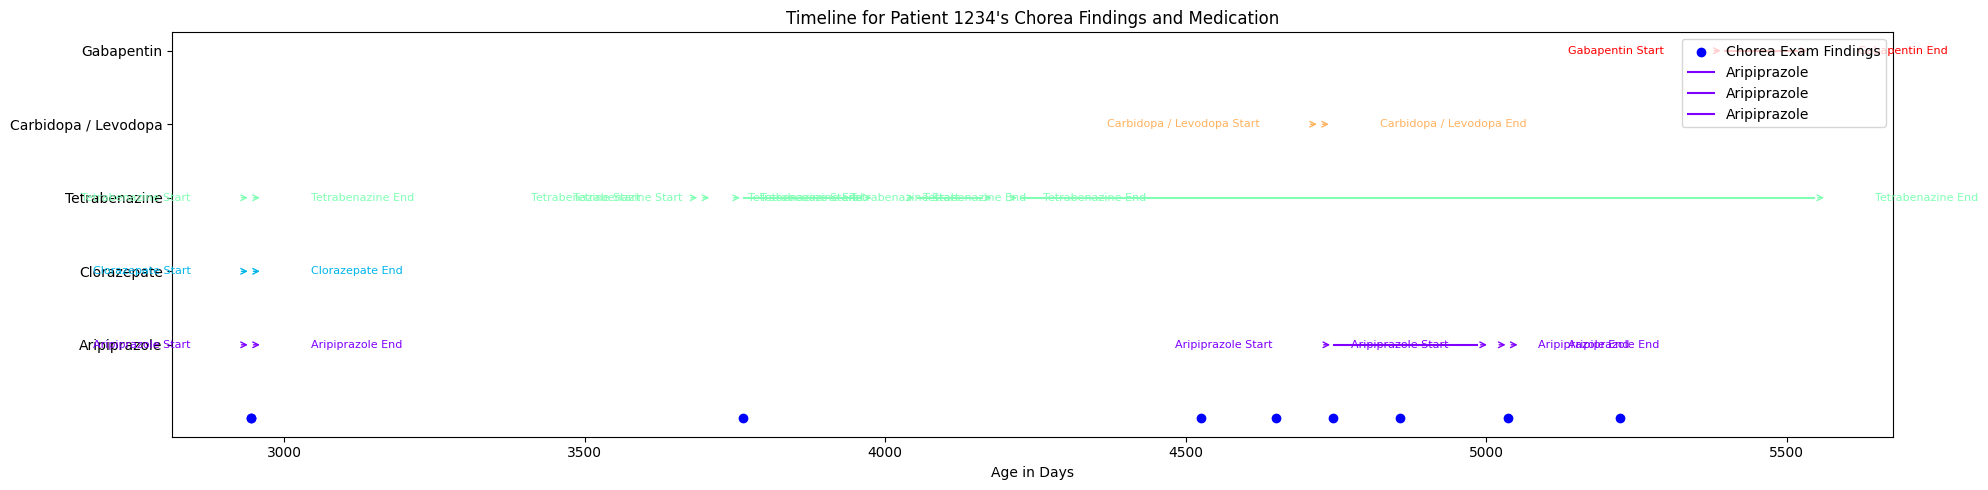

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have read the CSVs into pandas DataFrames named medications_df, clinical_diagnosis_df, and exam_findings_df
medications_df = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "medication", model = "flexible").text), sep='\t')
clinical_diagnosis_df = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "clinical_diagnosis", model = "flexible").text), sep='\t')
exam_findings_df = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "exam_findings", model = "flexible").text), sep='\t')


# Filtering the data for the patient with uuid "1234"
meds_patient = medications_df[(medications_df['patient_uuid'] == "dceb636a-56db-4c19-876e-b11c743b701d") & (medications_df['medication_indication'].str.contains("chorea", case=False, na=False))]
diag_patient = clinical_diagnosis_df[(clinical_diagnosis_df['patient_uuid'] == "dceb636a-56db-4c19-876e-b11c743b701d") & (clinical_diagnosis_df['clinical_diagnosis'].str.contains("chorea", case=False, na=False))]
exam_patient = exam_findings_df[(exam_findings_df['patient_uuid'] == "dceb636a-56db-4c19-876e-b11c743b701d") & (exam_findings_df['exam_finding'].str.contains("chorea", case=False, na=False))]

# Convert age in days to years for better readability in the plot
meds_patient['medication_age_years_firstDate'] = meds_patient['medication_age_days_firstDate'] / 365.25
meds_patient['medication_age_years_lastDate'] = meds_patient['medication_age_days_lastDate'] / 365.25
exam_patient['exam_age_years'] = exam_patient['exam_age_days'] / 365.25

# Assuming you have read the CSVs into pandas DataFrames named meds_patient, diag_patient, and exam_patient

# Make sure to filter the medications DataFrame for the particular patient with patient_uuid "1234"
meds_patient = meds_patient[meds_patient['patient_uuid'] == "dceb636a-56db-4c19-876e-b11c743b701d"]

# Now we create a unique color for each medication.

import matplotlib.pyplot as plt
import numpy as np

# Assuming meds_patient, diag_patient, and exam_patient are already defined and filtered for patient_uuid "1234"

# Unique medications and colors setup
unique_medications = meds_patient['medication'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_medications)))
medication_color_map = dict(zip(unique_medications, colors))

# Plotting
plt.figure(figsize=(20, 5))  # Adjust the size of the plot as needed

# Plot the exam findings
plt.scatter(exam_patient['exam_age_days'], np.zeros(len(exam_patient)), color='blue', label='Chorea Exam Findings')

# Vertical position for each medication line
vertical_positions = np.linspace(1, len(unique_medications), num=len(unique_medications))

# Plot each medication period with a different color and with arrows
for idx, (medication, y_pos) in enumerate(zip(unique_medications, vertical_positions)):
    medication_data = meds_patient[meds_patient['medication'] == medication]
    for _, row in medication_data.iterrows():
        # Draw a line for the period the medication was taken
        plt.hlines(y=y_pos, xmin=row['medication_age_days_firstDate'], xmax=row['medication_age_days_lastDate'],
                   color=medication_color_map[medication], label=medication if idx == 0 else "")

        # Add arrows and text for the start and end of the medication
        plt.annotate('', xy=(row['medication_age_days_firstDate'], y_pos), xytext=(row['medication_age_days_firstDate'] - 20, y_pos),
                     arrowprops=dict(arrowstyle="->", color=medication_color_map[medication]))
        plt.annotate('', xy=(row['medication_age_days_lastDate'], y_pos), xytext=(row['medication_age_days_lastDate'] + 20, y_pos),
                     arrowprops=dict(arrowstyle="<-", color=medication_color_map[medication]))

        plt.text(row['medication_age_days_firstDate'] - 100, y_pos, f'{medication} Start', va='center', ha='right',
                 fontsize=8, color=medication_color_map[medication])
        plt.text(row['medication_age_days_lastDate'] + 100, y_pos, f'{medication} End', va='center', ha='left',
                 fontsize=8, color=medication_color_map[medication])

# Customize the plot
plt.yticks(vertical_positions, unique_medications)
plt.xlabel('Age in Days')
plt.title(f"Timeline for Patient 1234's Chorea Findings and Medication")
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()




/tmp/ipykernel_88/3055954864.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meds_patient['medication_age_years_firstDate'] = meds_patient['medication_age_days_firstDate'] / 365.25
/tmp/ipykernel_88/3055954864.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meds_patient['medication_age_years_lastDate'] = meds_patient['medication_age_days_lastDate'] / 365.25
/tmp/ipykernel_88/3055954864.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

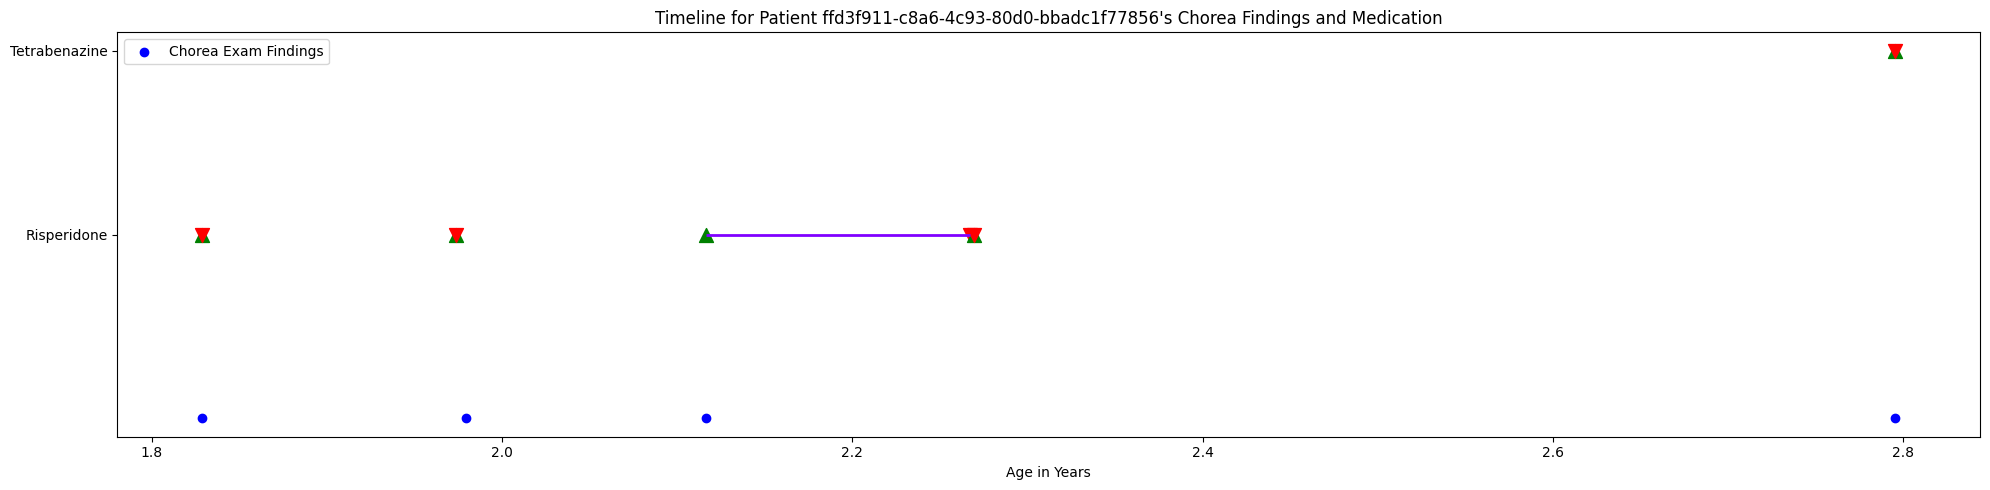

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np

import matplotlib.pyplot as plt



# Assuming you have read the CSVs into pandas DataFrames named medications_df, clinical_diagnosis_df, and exam_findings_df
medications_df = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "medication", model = "flexible").text), sep='\t')
clinical_diagnosis_df = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "clinical_diagnosis", model = "flexible").text), sep='\t')
exam_findings_df = pd.read_csv(io.StringIO(fapi.get_entities_tsv(project, workspace, "exam_findings", model = "flexible").text), sep='\t')


# Filtering the data for the patient with uuid "1234"
meds_patient = medications_df[(medications_df['patient_uuid'] == "ffd3f911-c8a6-4c93-80d0-bbadc1f77856") & (medications_df['medication_indication'].str.contains("chorea|choreoathetosis", case=False, na=False))]
diag_patient = clinical_diagnosis_df[(clinical_diagnosis_df['patient_uuid'] == "ffd3f911-c8a6-4c93-80d0-bbadc1f77856") & (clinical_diagnosis_df['clinical_diagnosis'].str.contains("chorea|choreoathetosis", case=False, na=False))]
exam_patient = exam_findings_df[(exam_findings_df['patient_uuid'] == "ffd3f911-c8a6-4c93-80d0-bbadc1f77856") & (exam_findings_df['exam_finding'].str.contains("chorea|choreoathetosis", case=False, na=False))]

# Convert age in days to years for better readability in the plot
meds_patient['medication_age_years_firstDate'] = meds_patient['medication_age_days_firstDate'] / 365.25
meds_patient['medication_age_years_lastDate'] = meds_patient['medication_age_days_lastDate'] / 365.25
exam_patient['exam_age_years'] = exam_patient['exam_age_days'] / 365.25

# Filtering code should go here...

# Unique medications and colors setup
unique_medications = meds_patient['medication'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_medications)))
medication_color_map = dict(zip(unique_medications, colors))

# Plotting
plt.figure(figsize=(20, 5))  # Adjust the size of the plot as needed

# Plot the exam findings
plt.scatter(exam_patient['exam_age_years'], np.zeros(len(exam_patient)), color='blue', label='Chorea Exam Findings')

# Vertical position for each medication line
vertical_positions = np.linspace(1, len(unique_medications), num=len(unique_medications))

# Plot each medication period with a different color and with arrows
for idx, (medication, y_pos) in enumerate(zip(unique_medications, vertical_positions)):
    medication_data = meds_patient[meds_patient['medication'] == medication]
    for _, row in medication_data.iterrows():
        # Draw a line for the period the medication was taken
        plt.hlines(y=y_pos, xmin=row['medication_age_years_firstDate'], xmax=row['medication_age_years_lastDate'],
                   color=medication_color_map[medication], lw=2)

        # Green upward arrow for start
        plt.scatter(row['medication_age_years_firstDate'], y_pos, color='green', marker='^', s=100)
        # Red downward arrow for end
        plt.scatter(row['medication_age_years_lastDate'], y_pos, color='red', marker='v', s=100)

# Customize the plot
plt.yticks(vertical_positions, unique_medications)
plt.xlabel('Age in Years')
plt.title(f"Timeline for Patient ffd3f911-c8a6-4c93-80d0-bbadc1f77856's Chorea Findings and Medication")
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()
